# Ensemble Learning


In the domain of time series anomaly detection, accurately identifying anomalies within complex datasets is a challenging task. To address this, we developed an ensemble method that combines the strengths of Isolation Forest and a GRU-based Autoencoder. The Isolation Forest, known for its robustness in detecting outliers, provides an initial detection of anomalous patterns, while the GRU Autoencoder captures temporal dependencies and reconstructs the time series to identify deviations. By leveraging both approaches, our ensemble method aims to improve detection accuracy and reduce false positives, offering a more comprehensive solution to the problem of anomaly detection in time series data.

In [30]:

import sys
import csv
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, make_scorer
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from skopt import BayesSearchCV
from skopt.space import Integer, Real
import torch
import torch.nn as nn
import torch.optim as optim
from scipy.stats import skew, kurtosis
from scipy.fft import fft

csv.field_size_limit(sys.maxsize)

#anomaly types mapping
anomaly_types_df = pd.read_csv('/Users/tinahajinejad/Downloads/anomaly_types.csv', delimiter=';')
filename_to_anomaly_type = {row['name']: row['anomaly_type_2'] for _, row in anomaly_types_df.iterrows()}

#folder path containing the datasets
folder_path = '/Users/tinahajinejad/Desktop/ALS new project/AnomalyDatasets_2021/UCR_TimeSeriesAnomalyDatasets2021/FilesAreInHere/UCR_Anomaly_FullData'

#load time series data function
def load_time_series(file_path):
    data = pd.read_csv(file_path, header=None, sep='\t' if any(str(num) in file_path for num in [204, 205, 206, 207, 208, 225, 226, 242, 243]) else ',', engine='python')
    data = data.apply(pd.to_numeric, errors='coerce')
    return data.values.flatten()

#updated feature extraction function for Isolation Forest:
def extract_features(ts, window_size=300):
    features = []
    for i in range(0, len(ts) - window_size + 1, window_size):
        window = ts[i:i + window_size]
        
        # Basic statistics
        mean_val = np.mean(window)
        std_val = np.std(window)
        min_val = np.min(window)
        max_val = np.max(window)
        perc25 = np.percentile(window, 25)
        perc75 = np.percentile(window, 75)
        # Skewness and Kurtosis
        skewness = skew(window)
        skewness = 0 if np.isnan(skewness) or np.isinf(skewness) else skewness
        kurt = kurtosis(window)
        kurt = 0 if np.isnan(kurt) or np.isinf(kurt) else kurt
        # Fourier transform coefficients
        fft_coeffs = np.abs(fft(window))[:10]

        feature_vector = [mean_val, std_val, min_val, max_val, perc25, perc75, skewness, kurt] + list(fft_coeffs)
        features.append(feature_vector)
    
    return np.array(features)

def pad_data(data, window_size=10):
    padding_length = (window_size - len(data) % window_size) % window_size
    return np.pad(data, (0, padding_length), 'constant')

#reshaping the padded data for GRU
def reshape_data(data, window_size=300):
    if len(data) < window_size:
        return torch.tensor([])  # returns an empty tensor if data is too short
    padded_data = pad_data(data, window_size)
    return torch.tensor(padded_data.reshape(-1, window_size, 1), dtype=torch.float32)

#scaling function to normalize data for GRU
def scale_data(train_data, test_data, window_size=300):
    scaler = StandardScaler()
    train_data = scaler.fit_transform(train_data.reshape(-1, 1)).reshape(-1, window_size, 1)
    test_data = scaler.transform(test_data.reshape(-1, 1)).reshape(-1, window_size, 1)
    return train_data, test_data


class GRUAutoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(GRUAutoencoder, self).__init__()
        self.encoder = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.decoder = nn.GRU(hidden_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        _, h = self.encoder(x)
        h_repeated = h.repeat(x.size(1), 1, 1).permute(1, 0, 2)
        decoded, _ = self.decoder(h_repeated)
        out = self.fc(decoded)
        return out

#the training function for GRU
def train_model(model, train_data, num_epochs=20, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        output = model(train_data)
        output = output[:, :train_data.size(1), :]
        loss = criterion(output, train_data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Evaluating the model's performance with possible "wiggle room"
def evaluate_prediction(predicted_center, anomaly_start, anomaly_end):
    L = anomaly_end - anomaly_start + 1
    min_val = min(anomaly_start - L, anomaly_start - 100)
    max_val = max(anomaly_end + L, anomaly_end + 100)
    return min_val < predicted_center < max_val


### Hyperparameter Tuning for the Ensemble Method

In our ensemble method, we combine the strengths of two models: Isolation Forest and a GRU-based Autoencoder. To optimize the performance of these models, we performed hyperparameter tuning using Bayesian optimization. This approach allows us to efficiently explore the hyperparameter space to find the best configuration that maximizes the model's performance.

#### 1. Isolation Forest Tuning
- **Objective**: To optimize key hyperparameters of the Isolation Forest model, which is primarily responsible for identifying outliers in the time series data.
- **Hyperparameters Tuned**:
  - `n_estimators`: The number of trees in the forest.
  - `max_samples`: The number of samples to draw from the dataset to train each tree.
  - `contamination`: The proportion of anomalies expected in the dataset.
- **Process**: We randomly selected 25 datasets for hyperparameter tuning and used Bayesian optimization to search the hyperparameter space. The objective was to maximize the F1 score, ensuring a balance between precision and recall.

#### 2. GRU Autoencoder Tuning
- **Objective**: To fine-tune the GRU Autoencoder, which reconstructs the time series and identifies anomalies based on reconstruction error.
- **Hyperparameters Tuned**:
  - `window_size`: The size of the sliding window used to segment the time series data.
  - `num_epochs`: The number of training epochs to optimize the GRU model.
- **Process**: Similar to the Isolation Forest, we used Bayesian optimization on the same 25 datasets to identify the optimal window size and number of epochs that result in the best anomaly detection performance.

#### 3. Exclusion of Tuning Datasets
- **To ensure that the hyperparameter tuning process did not bias the final evaluation, we excluded the 25 datasets used for tuning from the main training and testing process. This step was crucial to maintaining the integrity and generalizability of the model’s performance on unseen data.**

#### 4. Ensemble Weighting
- After tuning each model individually, we combined their outputs in the ensemble. The weights assigned to each model's output were determined by their respective confidence levels, which were calculated based on the standard deviation of their anomaly scores. This confidence-based weighting helped balance the contributions of the Isolation Forest and GRU Autoencoder, depending on which model was more confident in its predictions for a given dataset.


In [31]:

all_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
tuning_files = np.random.choice(all_files, size=25, replace=False)


#Hyperparameter tuning for GRU Autoencoder using grid search
window_sizes = [100, 300]
num_epochs_list = [30, 15]
best_roc_auc = 0
best_params_gru = None

def train_and_evaluate_gru(window_size, num_epochs):
    print(f"Evaluating GRU with window_size={window_size} and num_epochs={num_epochs}...")

    all_scores = []
    all_labels = []
    for filename in tuning_files:
        ts = load_time_series(os.path.join(folder_path, filename))
        ts = (ts - np.min(ts)) / (np.max(ts))

        parts = filename[:-4].split('_')
        training_len = int(parts[-3])
        anomaly_start = int(parts[-2])
        anomaly_end = int(parts[-1])
        X_train = reshape_data(ts[:training_len], window_size=window_size)
        X_test = reshape_data(ts[training_len:], window_size=window_size)
        if X_train.nelement() == 0 or X_test.nelement() == 0:
            continue

        X_train, X_test = scale_data(X_train.numpy(), X_test.numpy(), window_size=window_size)
        X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)

        #GRU Autoencoder setup
        input_dim = X_train.size(2)
        hidden_dim = 64
        num_layers = 2
        gru_model = GRUAutoencoder(input_dim, hidden_dim, num_layers)
        train_model(gru_model, X_train, num_epochs=num_epochs)

        gru_model.eval()
        with torch.no_grad():
            reconstructions = gru_model(X_test)
            reconstructions = reconstructions[:, :X_test.size(1), :]
            gru_scores = nn.MSELoss(reduction='none')(reconstructions, X_test).mean(dim=2).mean(dim=1).numpy()

        true_labels = np.zeros(len(gru_scores))
        true_labels[anomaly_start // window_size:(anomaly_end // window_size) + 1] = 1

        all_scores.extend(gru_scores)
        all_labels.extend(true_labels)

    roc_auc = roc_auc_score(np.array(all_labels), np.array(all_scores))
    return roc_auc

for window_size, num_epochs in product(window_sizes, num_epochs_list):
    roc_auc = train_and_evaluate_gru(window_size, num_epochs)
    print(f"ROC AUC: {roc_auc:.4f}")
    if roc_auc > best_roc_auc:
        best_roc_auc = roc_auc
        best_params_gru = {'window_size': window_size, 'num_epochs': num_epochs}

print(f"Best hyperparameters for GRU Autoencoder: {best_params_gru}")


#Hyperparameter tuning for Isolation Forest using Bayesian optimization
tuning_features = []
tuning_labels = []

for filename in tuning_files:
    print(f"Tuning on file: {filename}")

    ts = load_time_series(os.path.join(folder_path, filename))
    ts = (ts - np.min(ts)) / (np.max(ts)) 
    parts = filename[:-4].split('_')
    training_len = int(parts[-3])
    anomaly_start = int(parts[-2])
    anomaly_end = int(parts[-1])

    train_features = extract_features(ts[:training_len], window_size=best_params_gru['window_size'])
    test_features = extract_features(ts[training_len:], window_size=best_params_gru['window_size'])
    if train_features.size == 0 or test_features.size == 0:
        print(f"Skipping {filename} due to empty feature extraction.")
        continue

    true_labels = np.zeros(len(test_features))
    true_labels[anomaly_start // best_params_gru['window_size']:(anomaly_end // best_params_gru['window_size']) + 1] = 1
    if len(test_features) == len(true_labels):
        tuning_features.append(test_features)
        tuning_labels.append(true_labels)
    else:
        print(f"Skipping {filename} due to mismatch in features and labels length.")

tuning_features = np.vstack(tuning_features)
tuning_labels = np.hstack(tuning_labels)

#Micro average for multiclass scenario
f1_scorer = make_scorer(f1_score, average='micro')

#search space for Isolation Forest
search_space = {
    'n_estimators': Integer(50, 1000),
    'max_samples': Real(0.1, 1.0),
    'contamination': Real(0.01, 0.1),
}
#Bayesian optimization for Isolation Forest
opt_iforest = BayesSearchCV(
    IsolationForest(random_state=42),
    search_spaces=search_space,
    n_iter=50,
    scoring=f1_scorer, 
    cv=5,
    random_state=42,
    n_jobs=-1
)

opt_iforest.fit(tuning_features, tuning_labels)

best_params_iforest = opt_iforest.best_params_
print(f"Best hyperparameters for Isolation Forest: {best_params_iforest}")




training_testing_files = [f for f in all_files if f not in tuning_files]


Evaluating GRU with window_size=100 and num_epochs=30...
ROC AUC: 0.4694
Evaluating GRU with window_size=100 and num_epochs=15...
ROC AUC: 0.4872
Evaluating GRU with window_size=300 and num_epochs=30...
ROC AUC: 0.4600
Evaluating GRU with window_size=300 and num_epochs=15...
ROC AUC: 0.4712
Best hyperparameters for GRU Autoencoder: {'window_size': 100, 'num_epochs': 15}
Tuning on file: 174_UCR_Anomaly_insectEPG2_3700_8000_8025.txt
Tuning on file: 006_UCR_Anomaly_DISTORTEDCIMIS44AirTemperature2_4000_5703_5727.txt
Tuning on file: 157_UCR_Anomaly_TkeepFirstMARS_3500_5365_5380.txt
Tuning on file: 195_UCR_Anomaly_sel840mECG1_17000_51370_51740.txt
Tuning on file: 163_UCR_Anomaly_apneaecg2_10000_20950_21100.txt
Tuning on file: 180_UCR_Anomaly_ltstdbs30791ES_20000_52600_52800.txt
Tuning on file: 045_UCR_Anomaly_DISTORTEDPowerDemand2_14000_23357_23717.txt
Tuning on file: 201_UCR_Anomaly_CHARISfive_10000_17001_17016.txt
Tuning on file: 211_UCR_Anomaly_Italianpowerdemand_38113_39240_39336.txt
Tun

Processing file 1/225
Processing file 2/225
Processing file 3/225
Processing file 4/225
Processing file 5/225
Processing file 6/225
Correct prediction for 130_UCR_Anomaly_GP711MarkerLFM5z4_4000_6527_6645.txt.


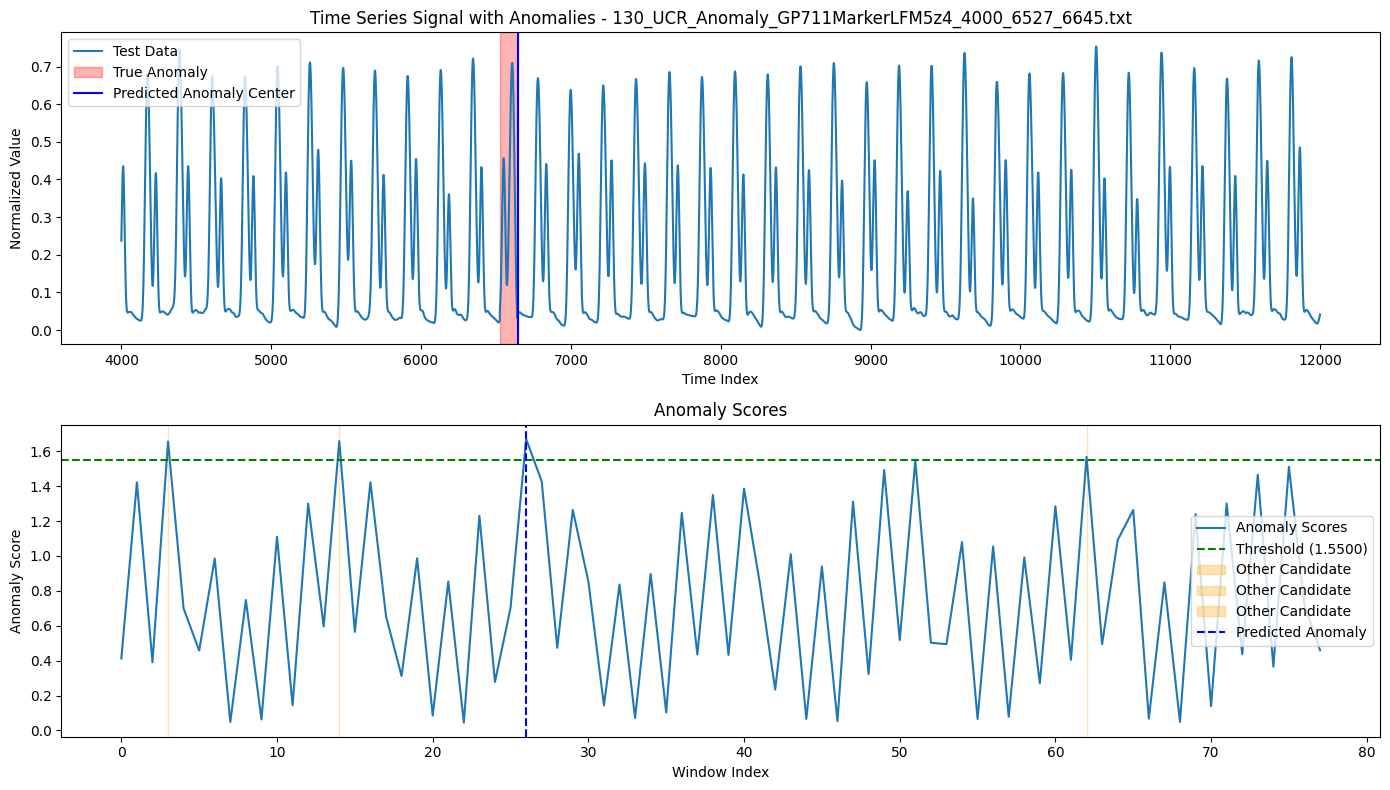

Processing file 7/225
Processing file 8/225
Processing file 9/225
Processing file 10/225
Processing file 11/225
Correct prediction for 042_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG6_7000_12190_12420.txt.


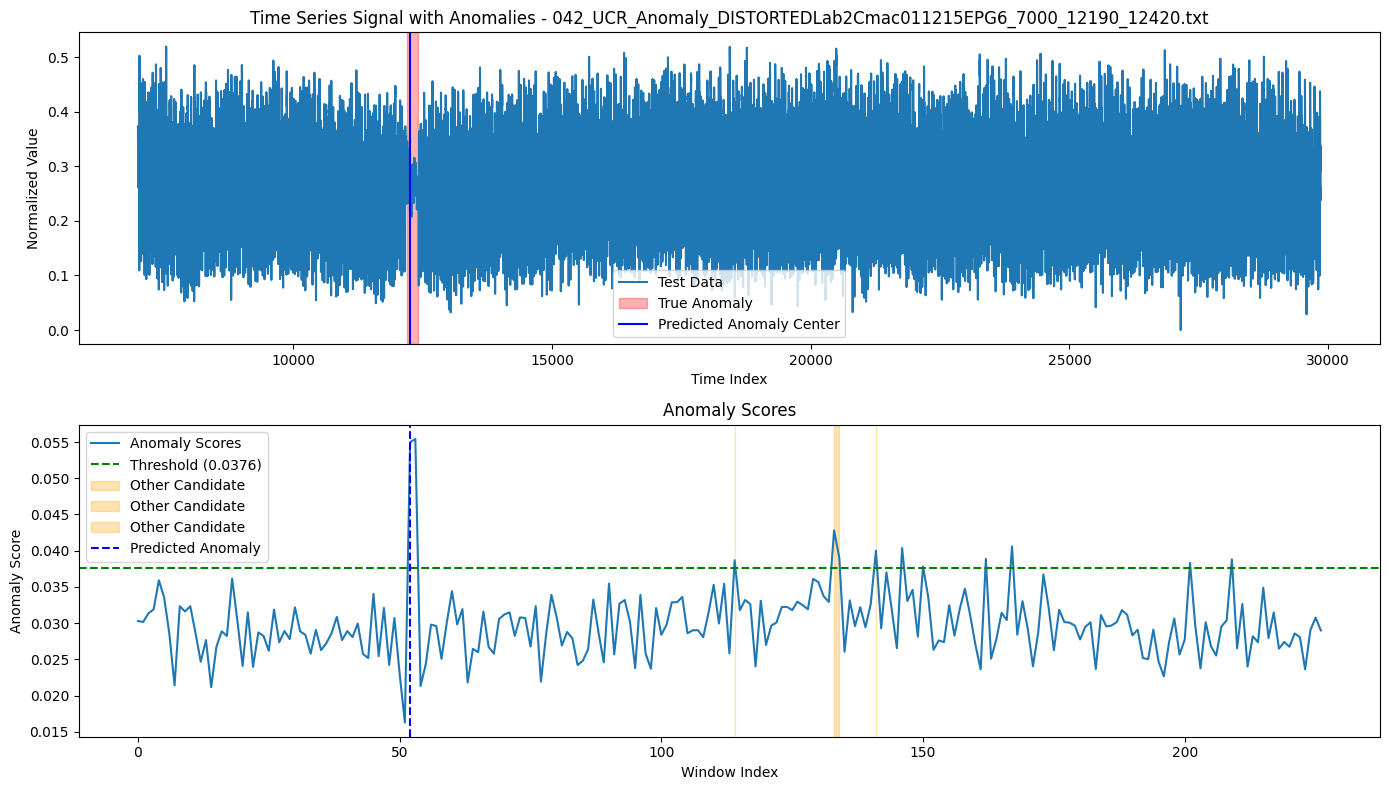

Processing file 12/225
Processing file 13/225
Skipping 204_UCR_Anomaly_CHARISfive_12412_15000_15070.txt due to empty feature extraction.
Processing file 14/225


/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_3287/3752982701.py:47: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window)
/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_3287/3752982701.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window)


Processing file 15/225
Processing file 16/225
Processing file 17/225
Processing file 18/225
Processing file 19/225
Correct prediction for 070_UCR_Anomaly_DISTORTEDltstdbs30791AI_17555_52600_52800.txt.


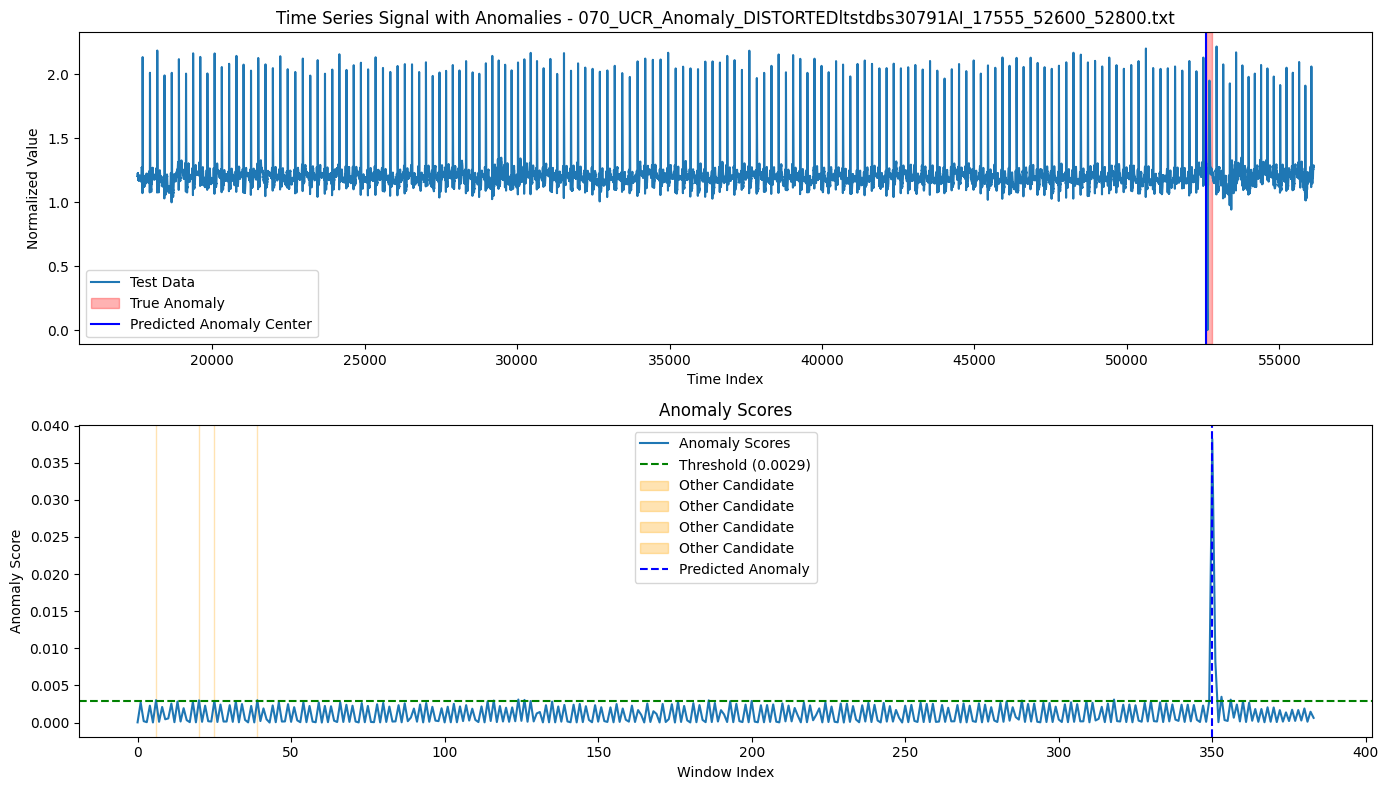

Processing file 20/225
Processing file 21/225
Processing file 22/225
Processing file 23/225
Processing file 24/225
Processing file 25/225
Processing file 26/225
Processing file 27/225
Correct prediction for 103_UCR_Anomaly_NOISETkeepThirdMARS_3500_4711_4809.txt.


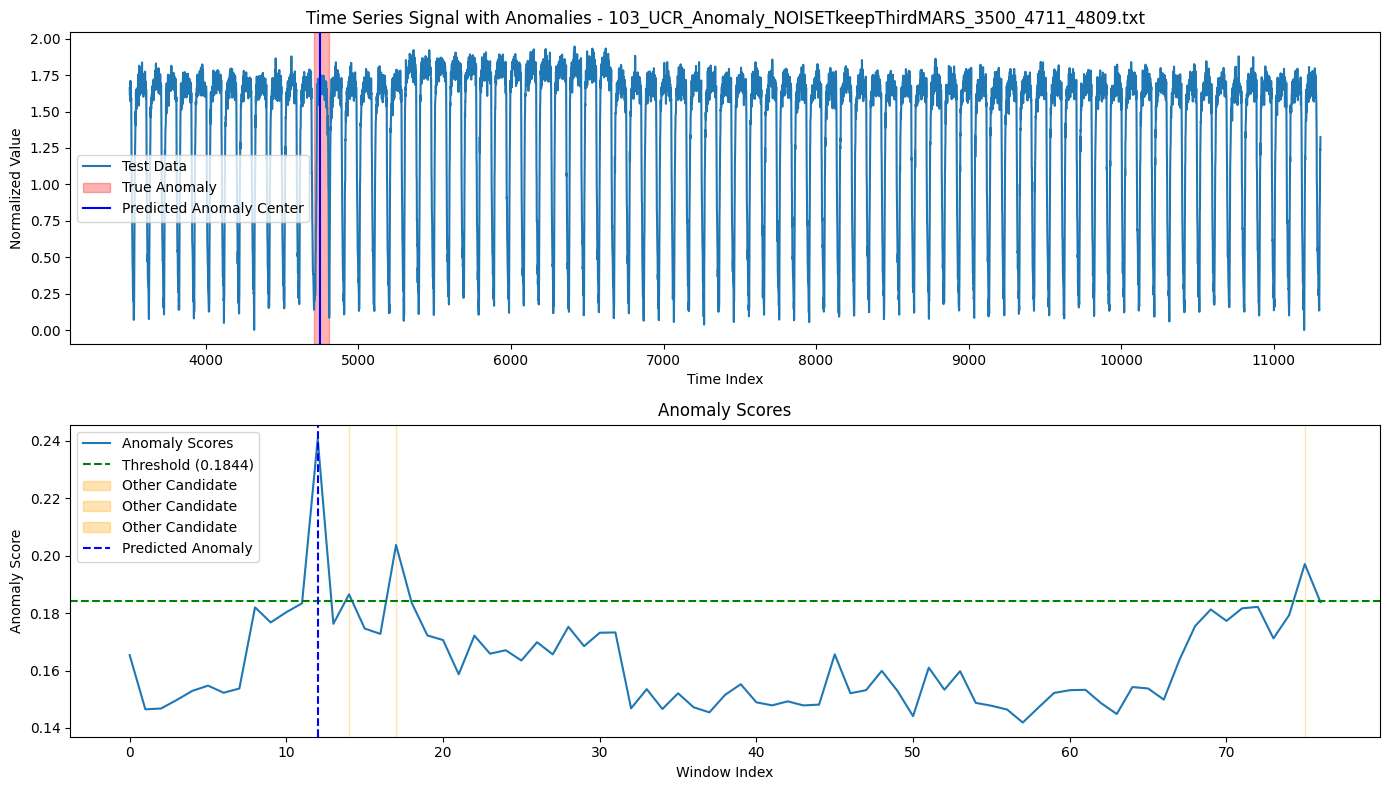

Processing file 28/225
Processing file 29/225
Correct prediction for 179_UCR_Anomaly_ltstdbs30791AS_23000_52600_52800.txt.


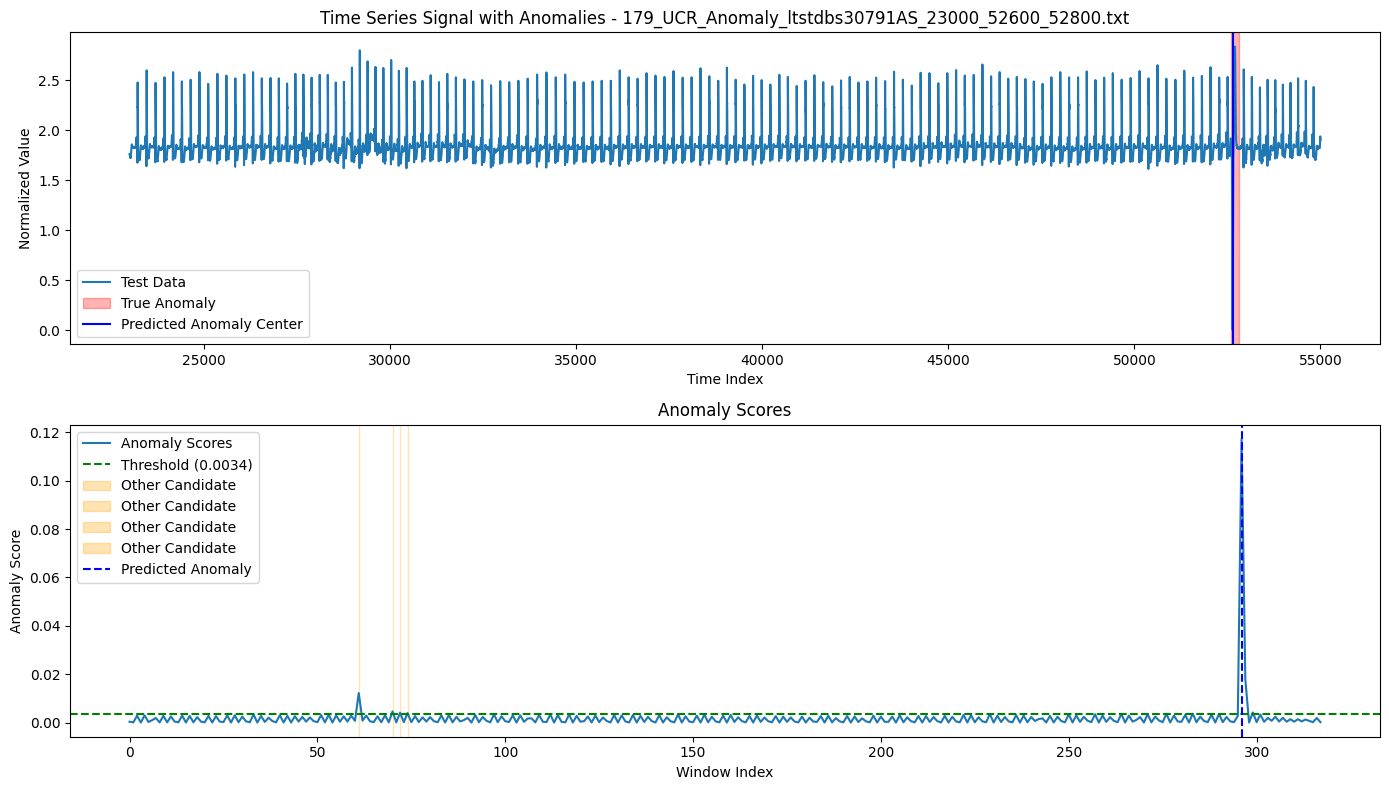

Processing file 30/225
Correct prediction for 178_UCR_Anomaly_ltstdbs30791AI_17555_52600_52800.txt.


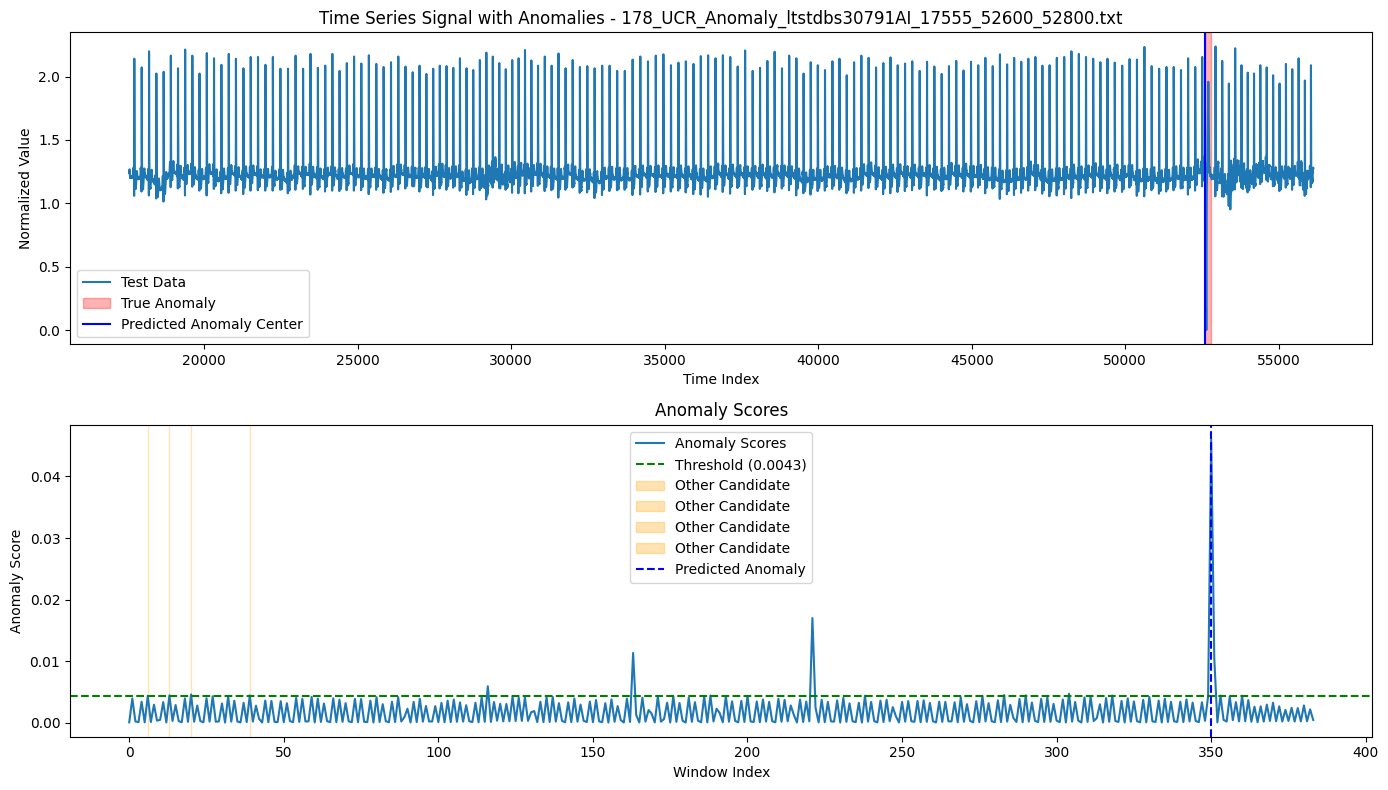

Processing file 31/225
Processing file 32/225
Skipping 225_UCR_Anomaly_mit14046longtermecg_81214_143000_143300.txt due to empty feature extraction.
Processing file 33/225
Processing file 34/225
Processing file 35/225
Processing file 36/225
Processing file 37/225
Processing file 38/225
Processing file 39/225
Processing file 40/225
Processing file 41/225
Correct prediction for 033_UCR_Anomaly_DISTORTEDInternalBleeding5_4000_6200_6370.txt.


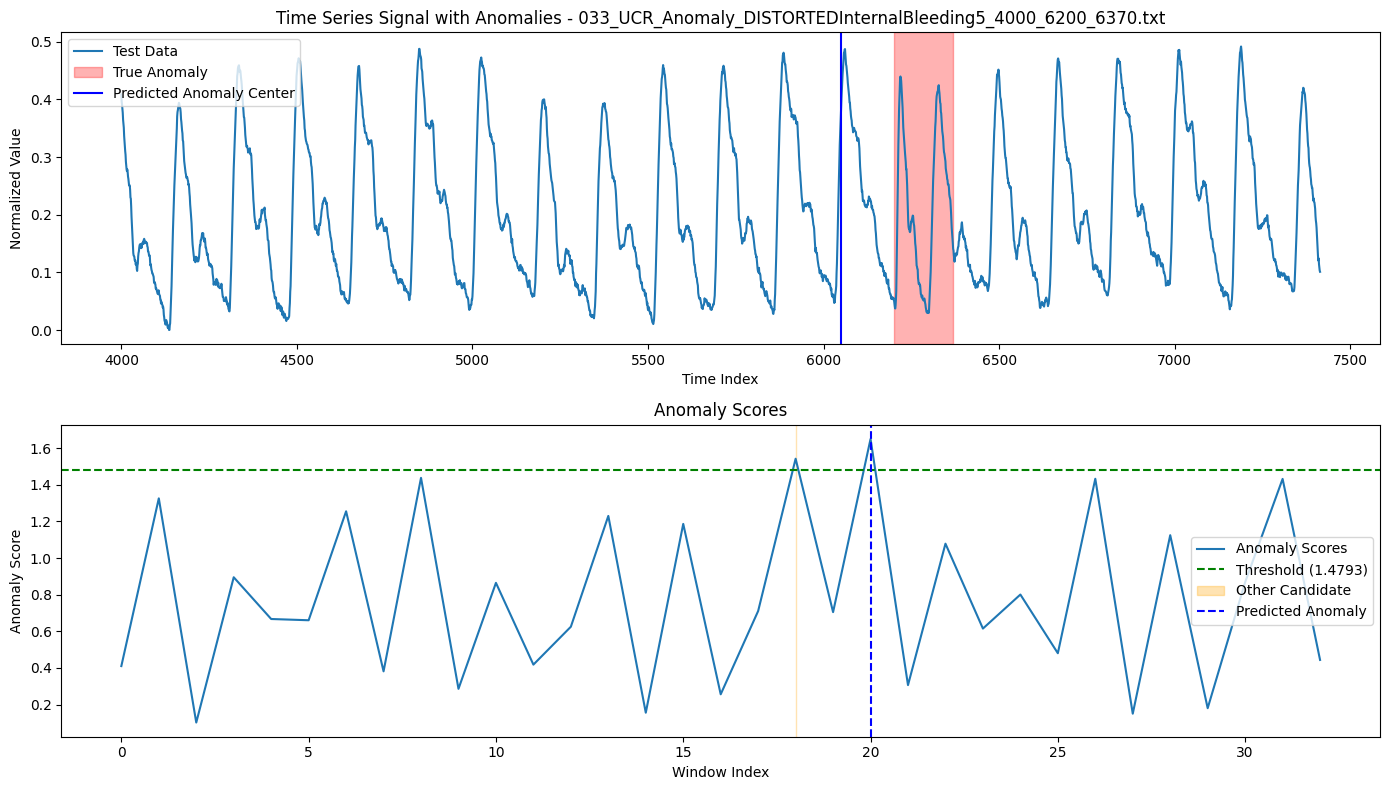

Processing file 42/225
Processing file 43/225
Processing file 44/225
Processing file 45/225
Processing file 46/225
Processing file 47/225
Processing file 48/225
Processing file 49/225
Processing file 50/225
Processing file 51/225
Processing file 52/225
Processing file 53/225
Processing file 54/225
Processing file 55/225
Processing file 56/225
Correct prediction for 141_UCR_Anomaly_InternalBleeding5_4000_6200_6370.txt.


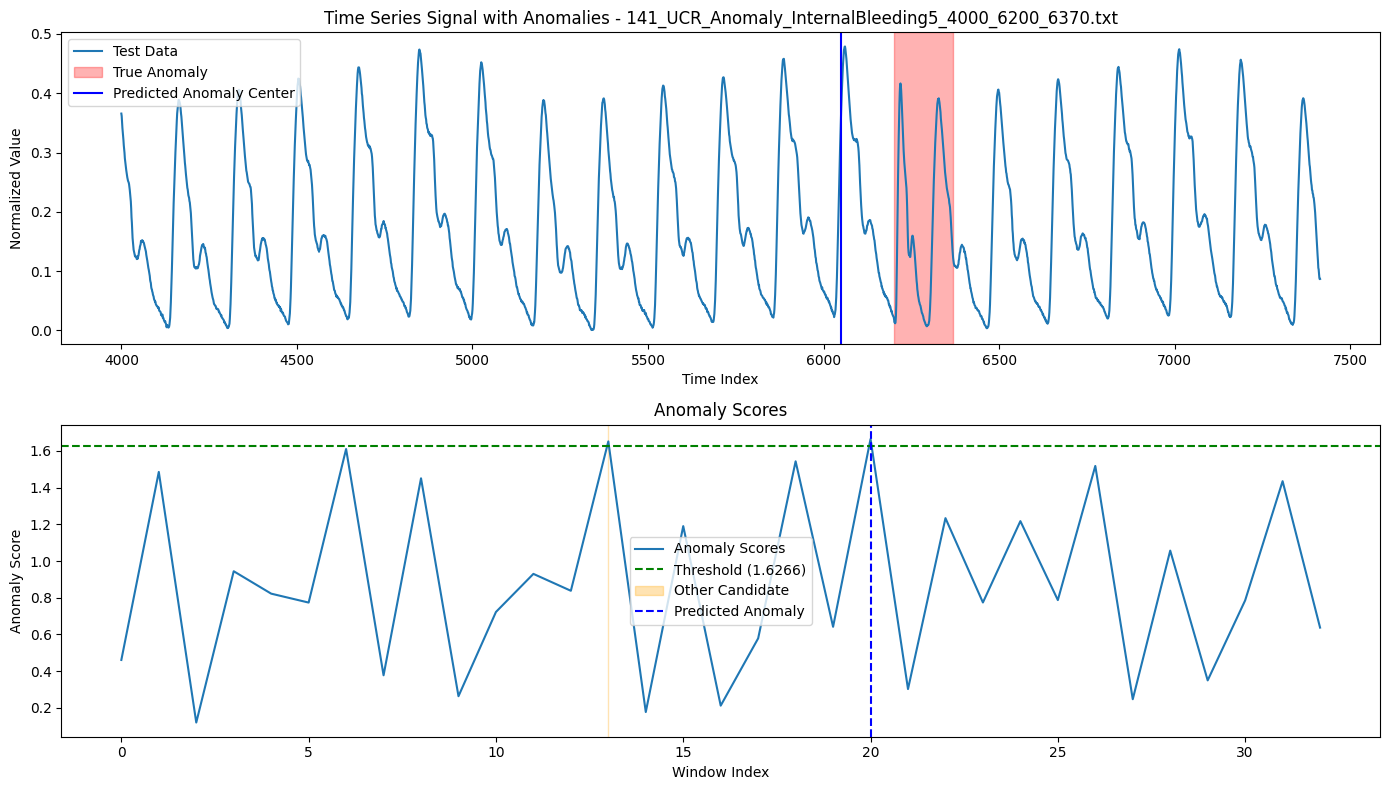

Processing file 57/225
Correct prediction for 041_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG5_7000_17390_17520.txt.


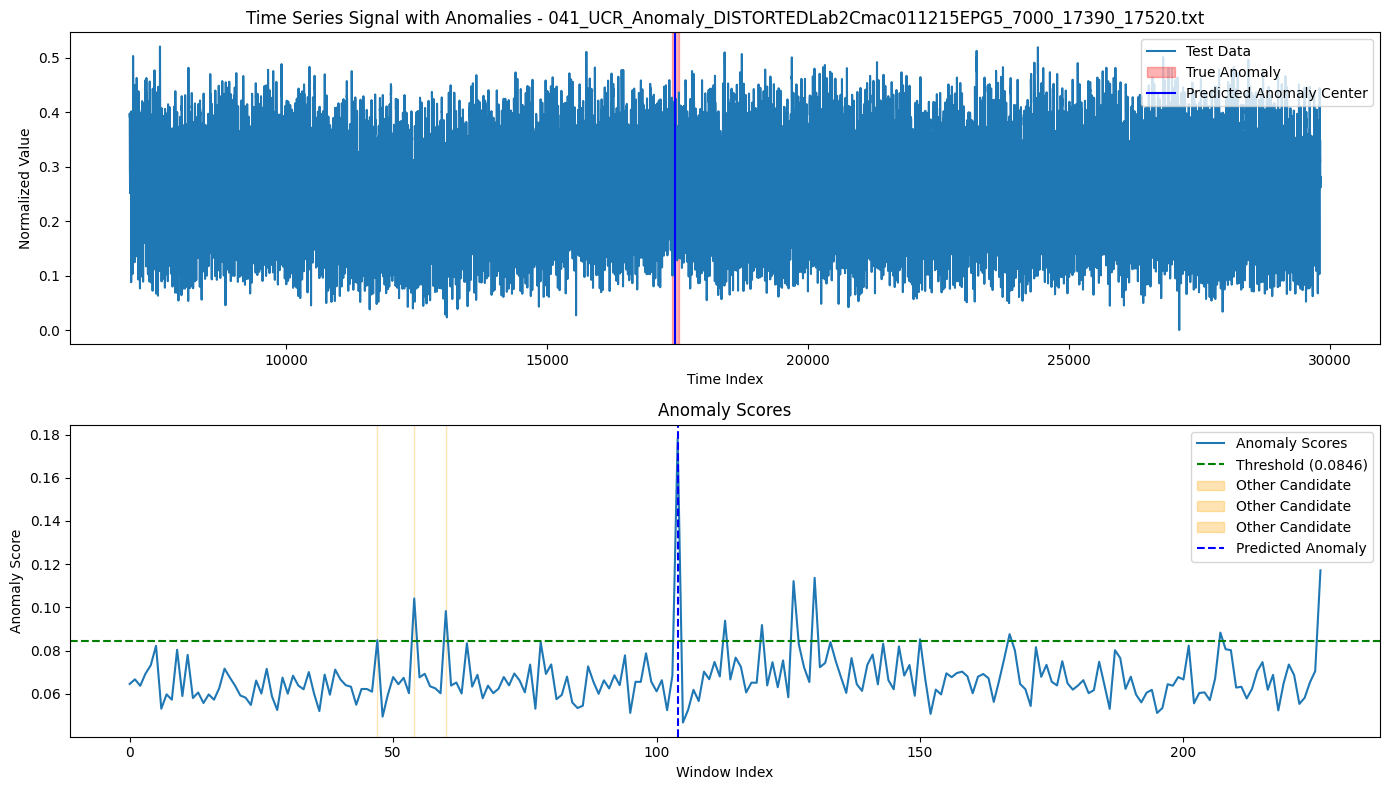

Processing file 58/225
Correct prediction for 151_UCR_Anomaly_MesoplodonDensirostris_10000_19280_19440.txt.


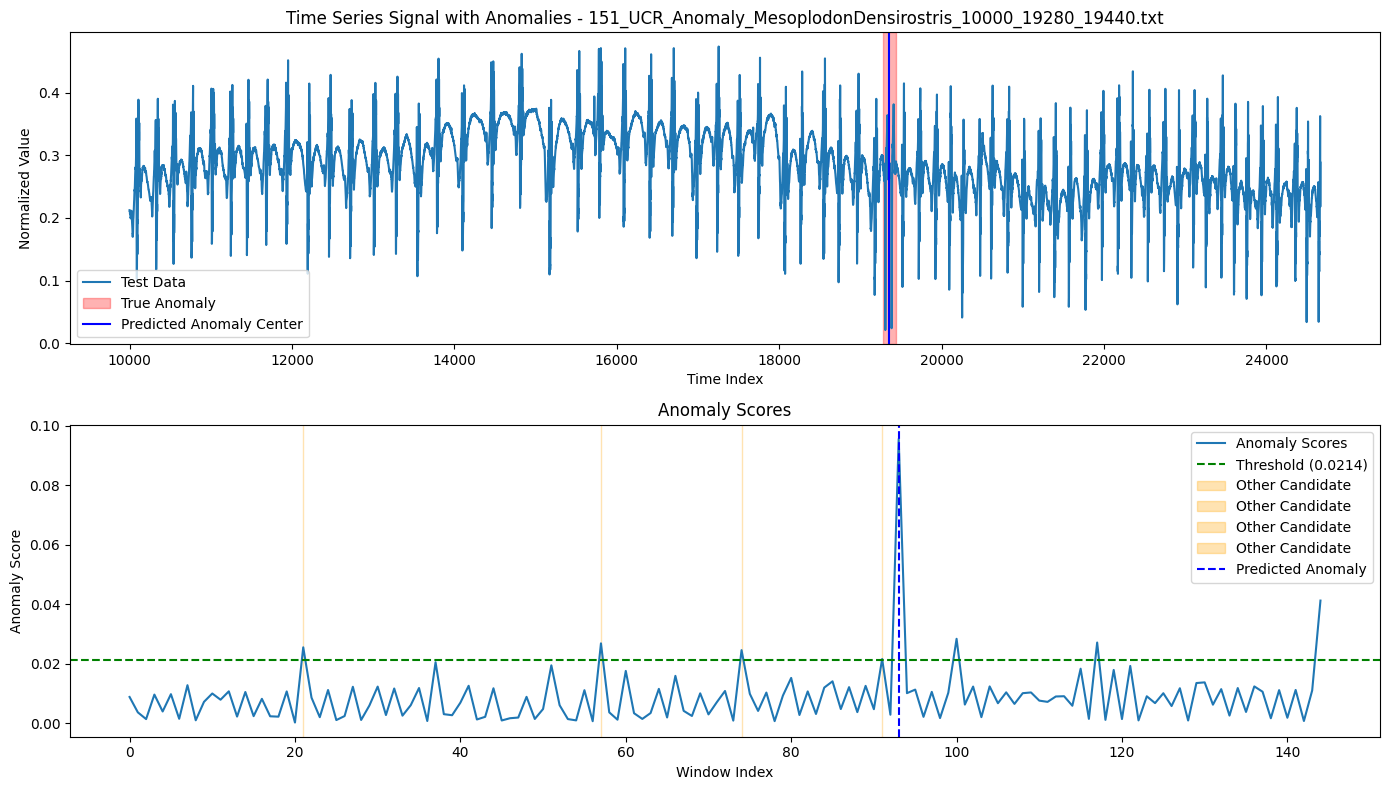

Processing file 59/225
Processing file 60/225
Processing file 61/225
Processing file 62/225
Processing file 63/225
Processing file 64/225
Processing file 65/225
Processing file 66/225
Processing file 67/225
Processing file 68/225
Processing file 69/225
Processing file 70/225
Processing file 71/225
Correct prediction for 084_UCR_Anomaly_DISTORTEDs20101mML2_12000_35774_35874.txt.


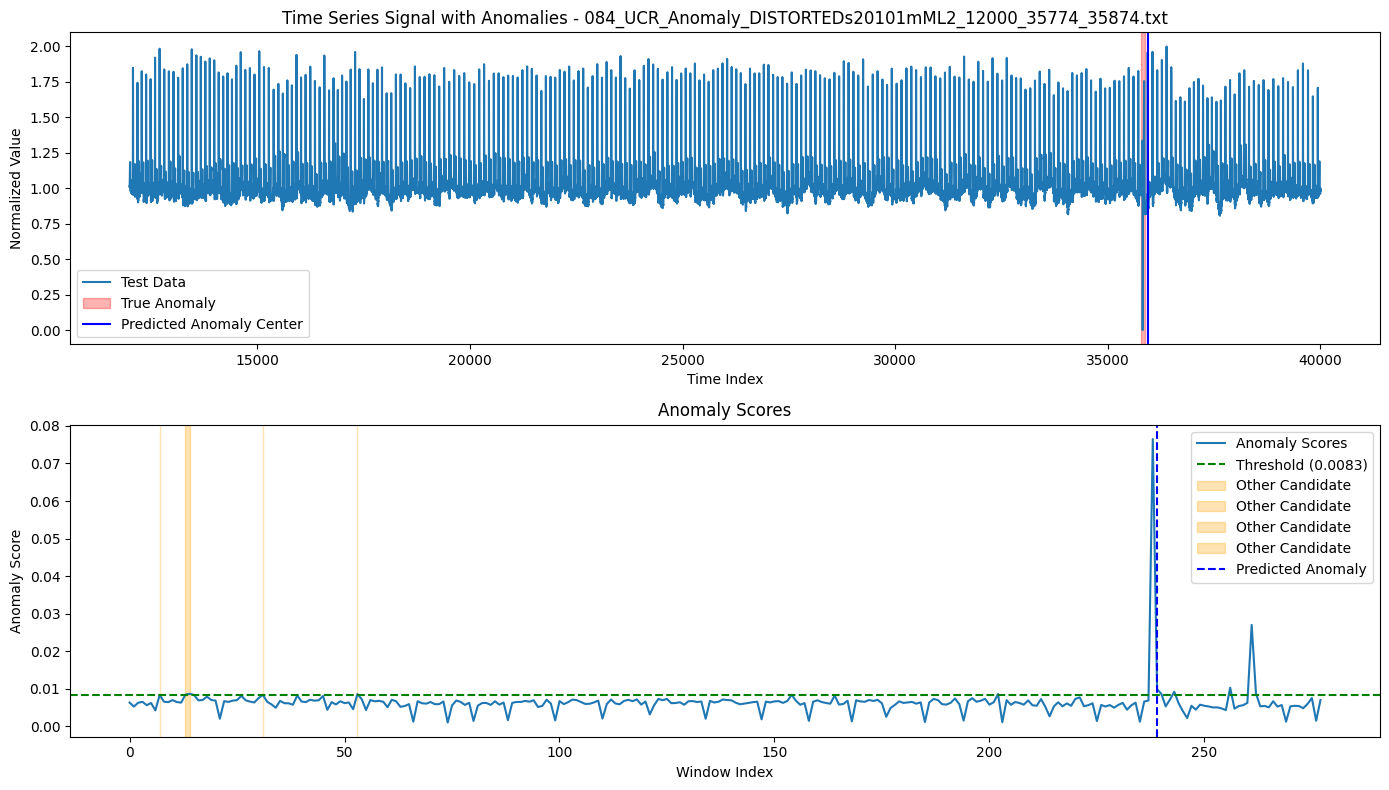

Processing file 72/225
Processing file 73/225
Processing file 74/225
Processing file 75/225
Processing file 76/225
Skipping 242_UCR_Anomaly_tilt12744mtable_100000_104630_104890.txt due to empty feature extraction.
Processing file 77/225
Processing file 78/225
Processing file 79/225
Processing file 80/225
Processing file 81/225
Processing file 82/225
Processing file 83/225
Processing file 84/225
Processing file 85/225
Processing file 86/225
Processing file 87/225
Processing file 88/225
Processing file 89/225
Skipping 208_UCR_Anomaly_CHARISten_5130_27929_27989.txt due to empty feature extraction.
Processing file 90/225
Processing file 91/225
Processing file 92/225
Processing file 93/225
Processing file 94/225
Processing file 95/225
Processing file 96/225
Skipping 226_UCR_Anomaly_mit14046longtermecg_96123_123000_123300.txt due to empty feature extraction.
Processing file 97/225
Processing file 98/225
Processing file 99/225
Processing file 100/225
Processing file 101/225
Processing file 10

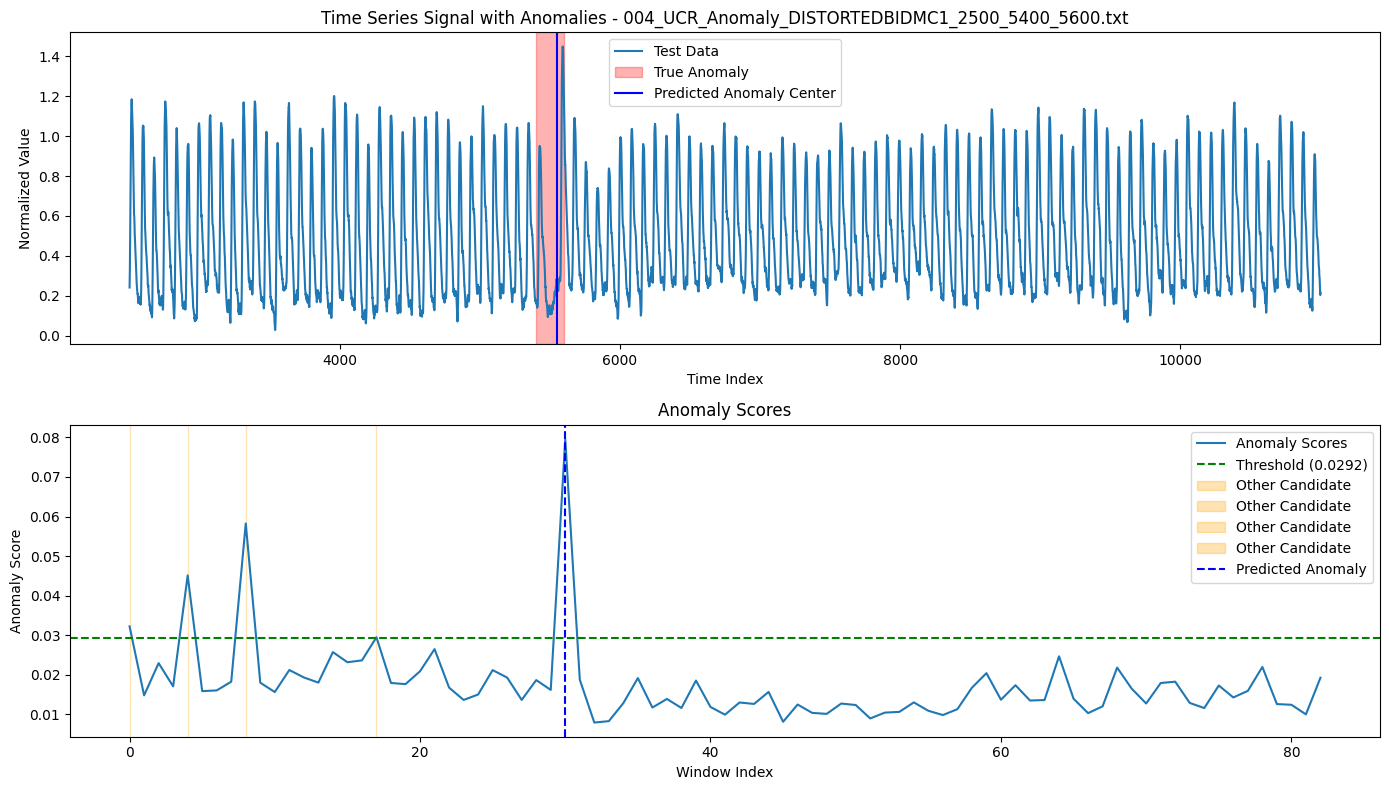

Processing file 114/225
Skipping 207_UCR_Anomaly_CHARISten_3165_26929_26989.txt due to empty feature extraction.
Processing file 115/225
Processing file 116/225
Processing file 117/225
Processing file 118/225
Processing file 119/225
Processing file 120/225
Processing file 121/225
Processing file 122/225
Processing file 123/225
Processing file 124/225
Processing file 125/225
Processing file 126/225
Processing file 127/225
Processing file 128/225
Processing file 129/225
Processing file 130/225
Processing file 131/225
Processing file 132/225
Correct prediction for 162_UCR_Anomaly_WalkingAceleration5_2700_5920_5979.txt.


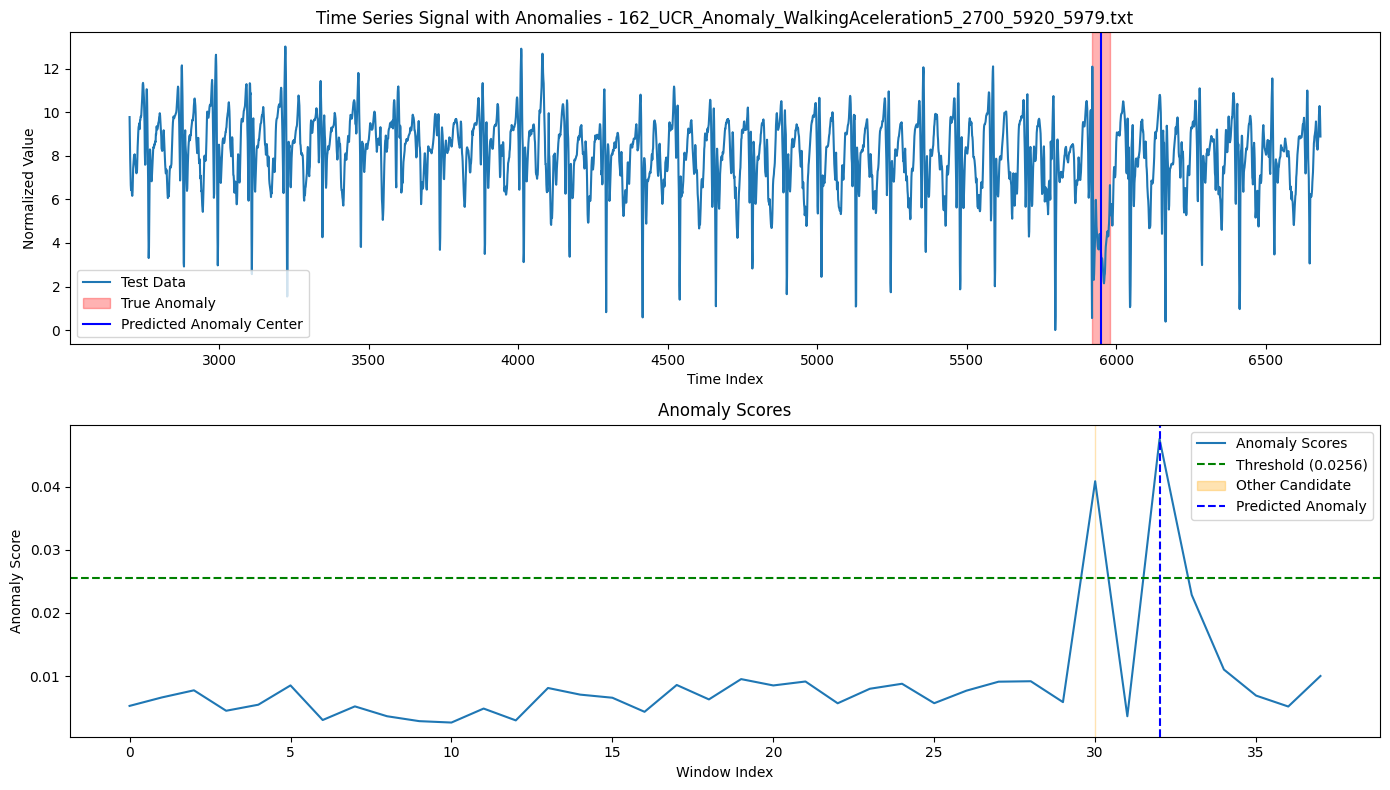

Processing file 133/225
Processing file 134/225
Correct prediction for 034_UCR_Anomaly_DISTORTEDInternalBleeding6_1500_3474_3629.txt.


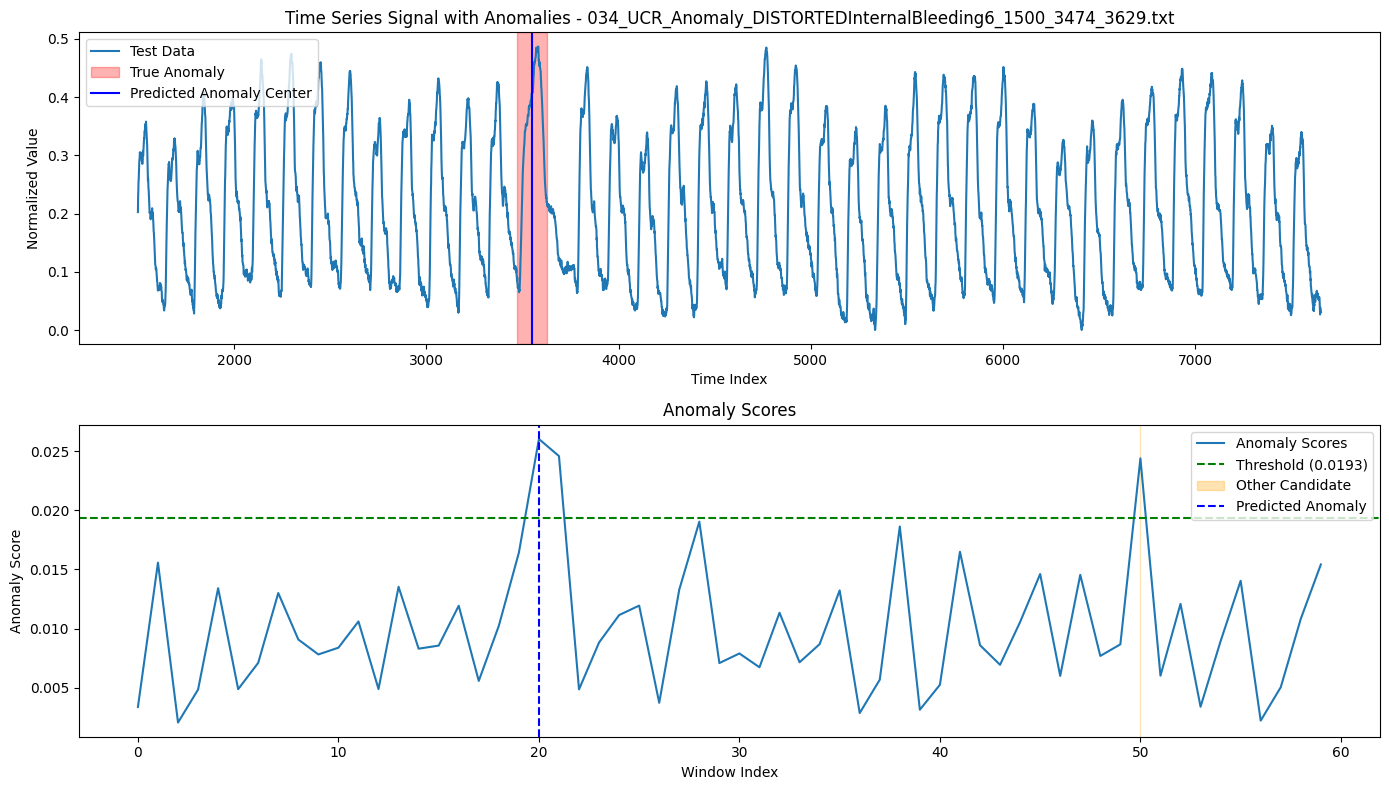

Processing file 135/225
Processing file 136/225
Processing file 137/225
Processing file 138/225
Processing file 139/225
Processing file 140/225
Processing file 141/225
Processing file 142/225
Correct prediction for 037_UCR_Anomaly_DISTORTEDLab2Cmac011215EPG1_5000_17210_17260.txt.


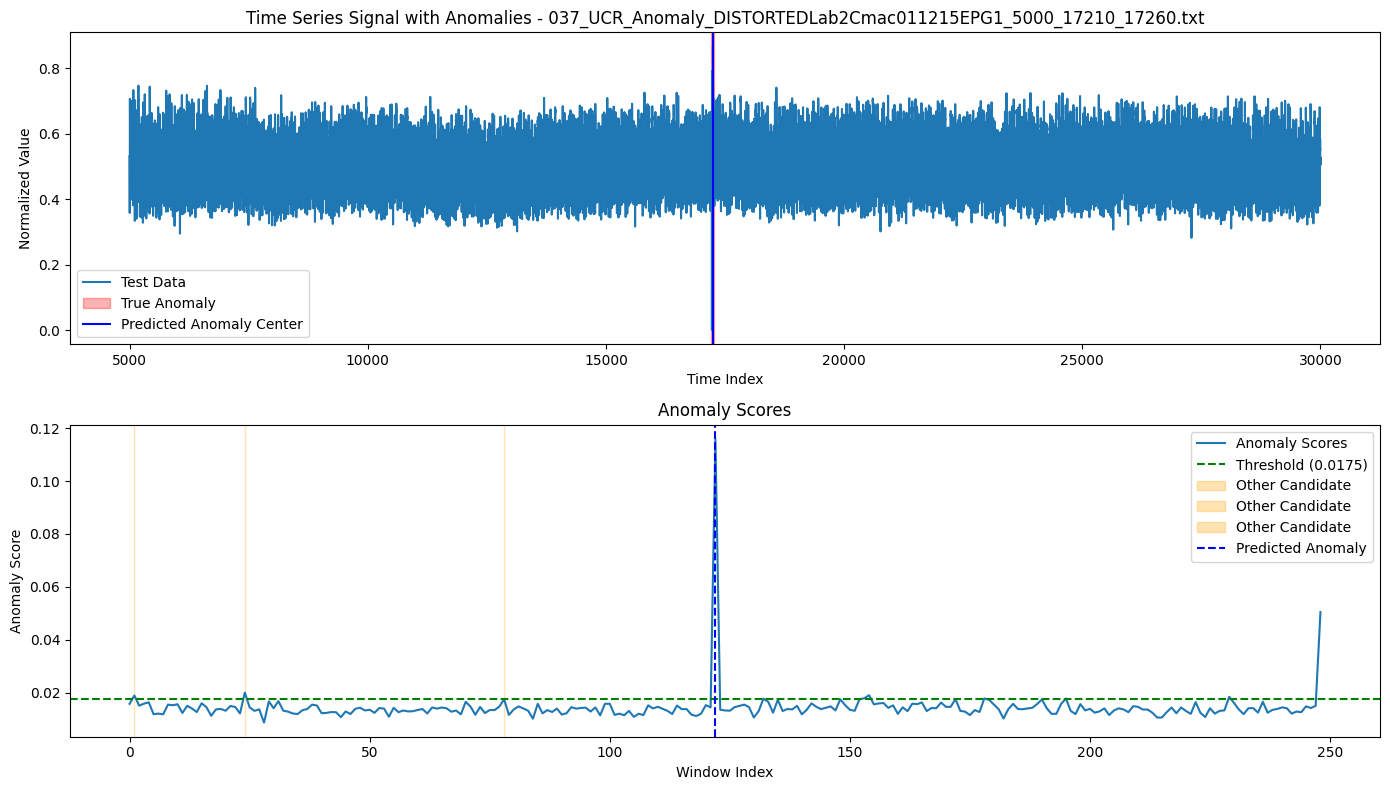

Processing file 143/225
Correct prediction for 249_UCR_Anomaly_weallwalk_2753_8285_8315.txt.


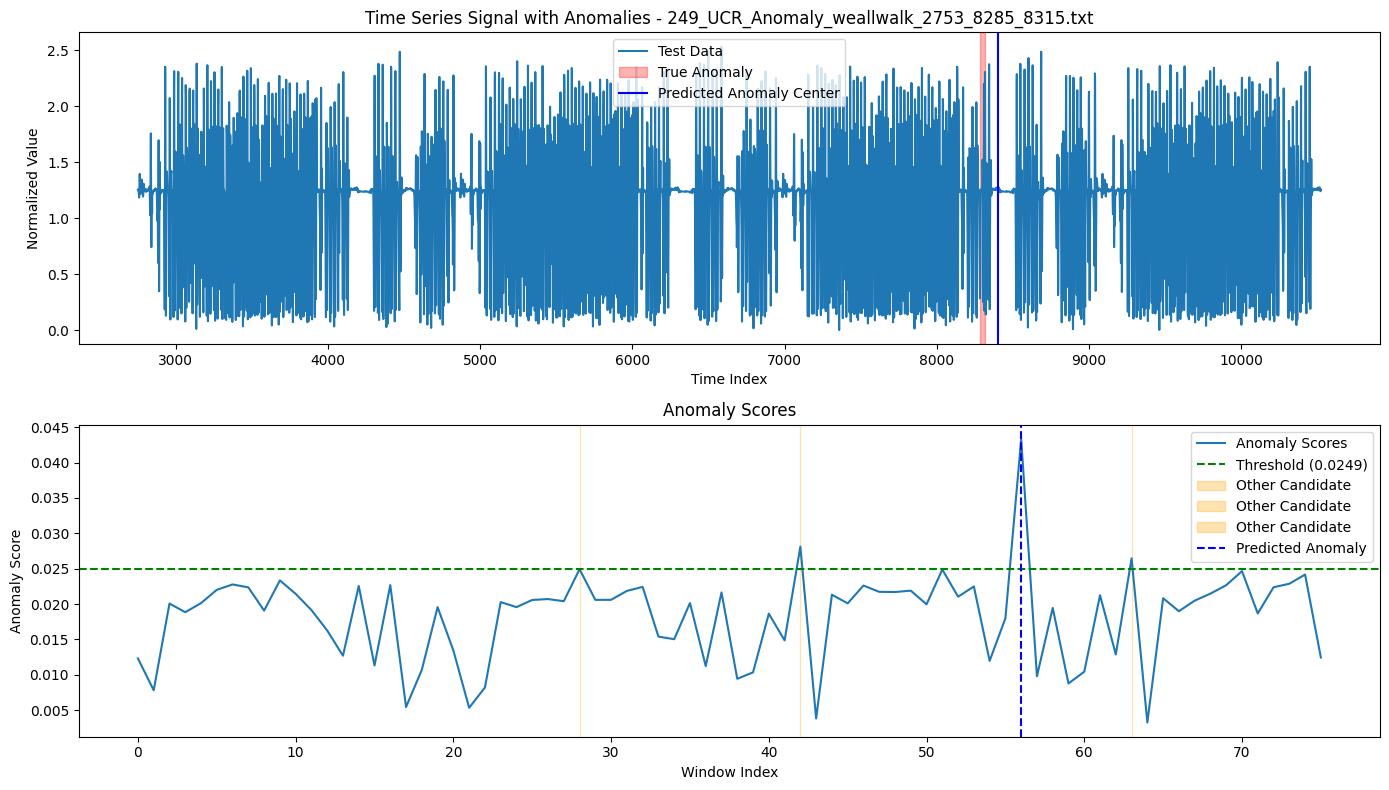

Processing file 144/225
Processing file 145/225
Processing file 146/225
Correct prediction for 071_UCR_Anomaly_DISTORTEDltstdbs30791AS_23000_52600_52800.txt.


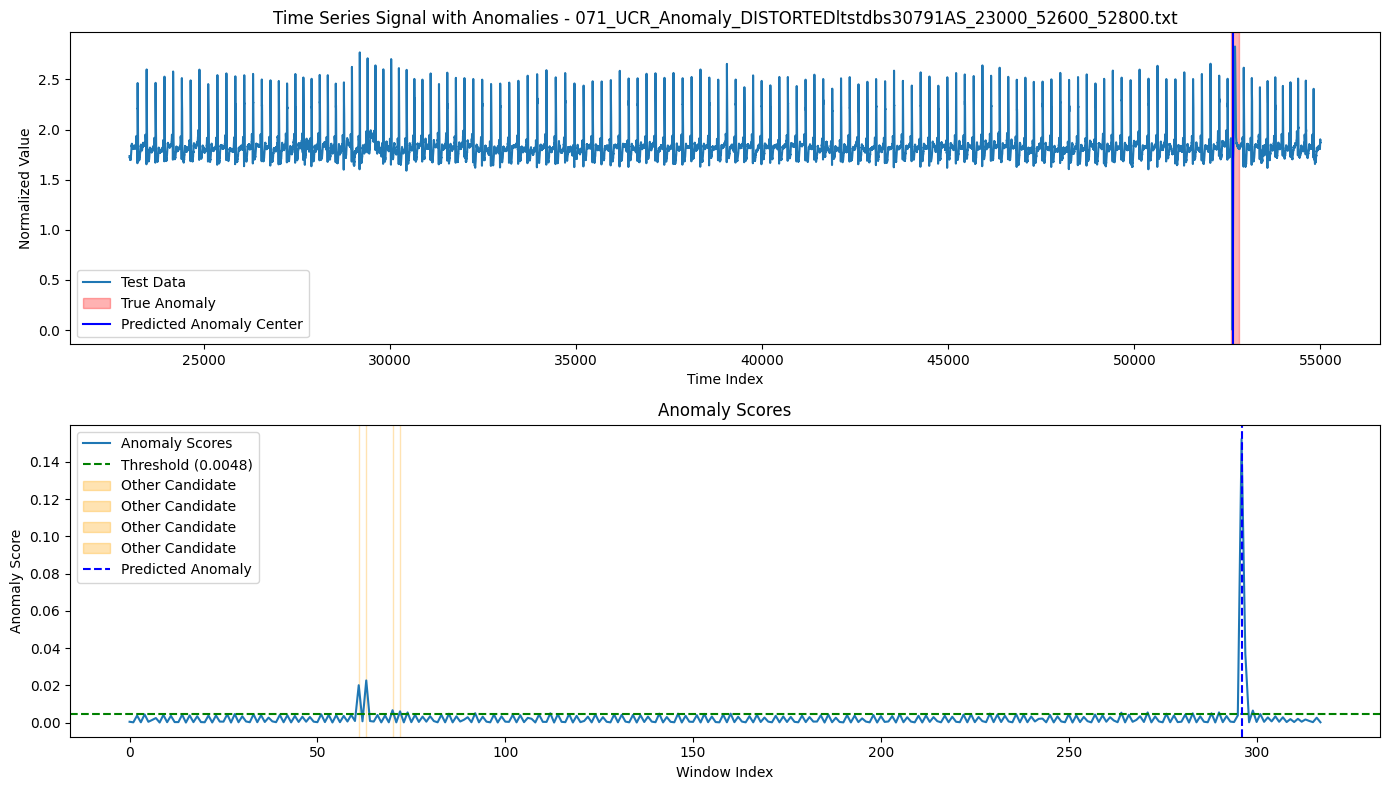

Processing file 147/225
Processing file 148/225
Processing file 149/225
Processing file 150/225
Processing file 151/225
Processing file 152/225
Processing file 153/225
Processing file 154/225
Processing file 155/225
Processing file 156/225
Processing file 157/225
Processing file 158/225
Skipping 243_UCR_Anomaly_tilt12744mtable_100000_203355_203400.txt due to empty feature extraction.
Processing file 159/225
Processing file 160/225
Correct prediction for 043_UCR_Anomaly_DISTORTEDMesoplodonDensirostris_10000_19280_19440.txt.


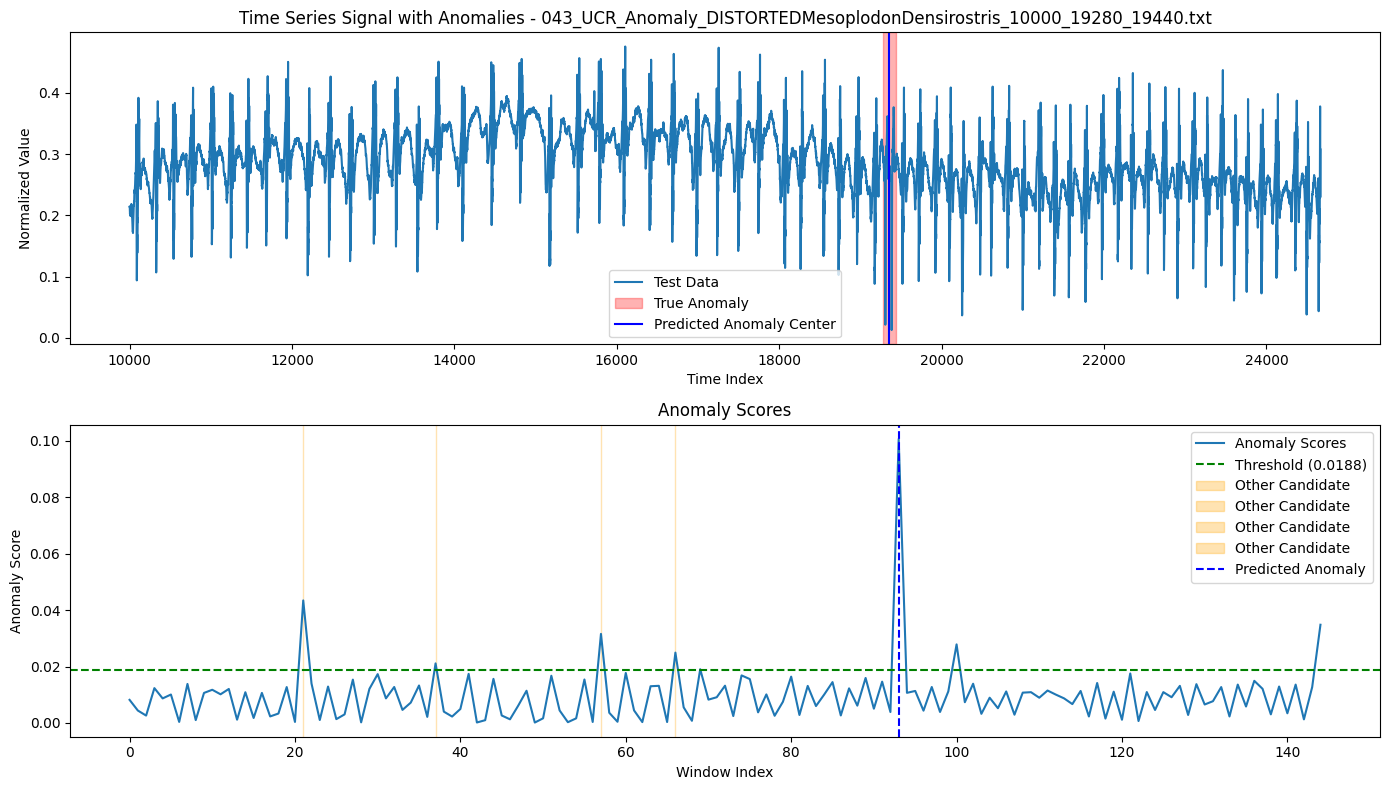

Processing file 161/225
Processing file 162/225
Processing file 163/225
Processing file 164/225
Processing file 165/225
Processing file 166/225
Processing file 167/225
Processing file 168/225
Processing file 169/225
Processing file 170/225
Correct prediction for 011_UCR_Anomaly_DISTORTEDECG1_10000_11800_12100.txt.


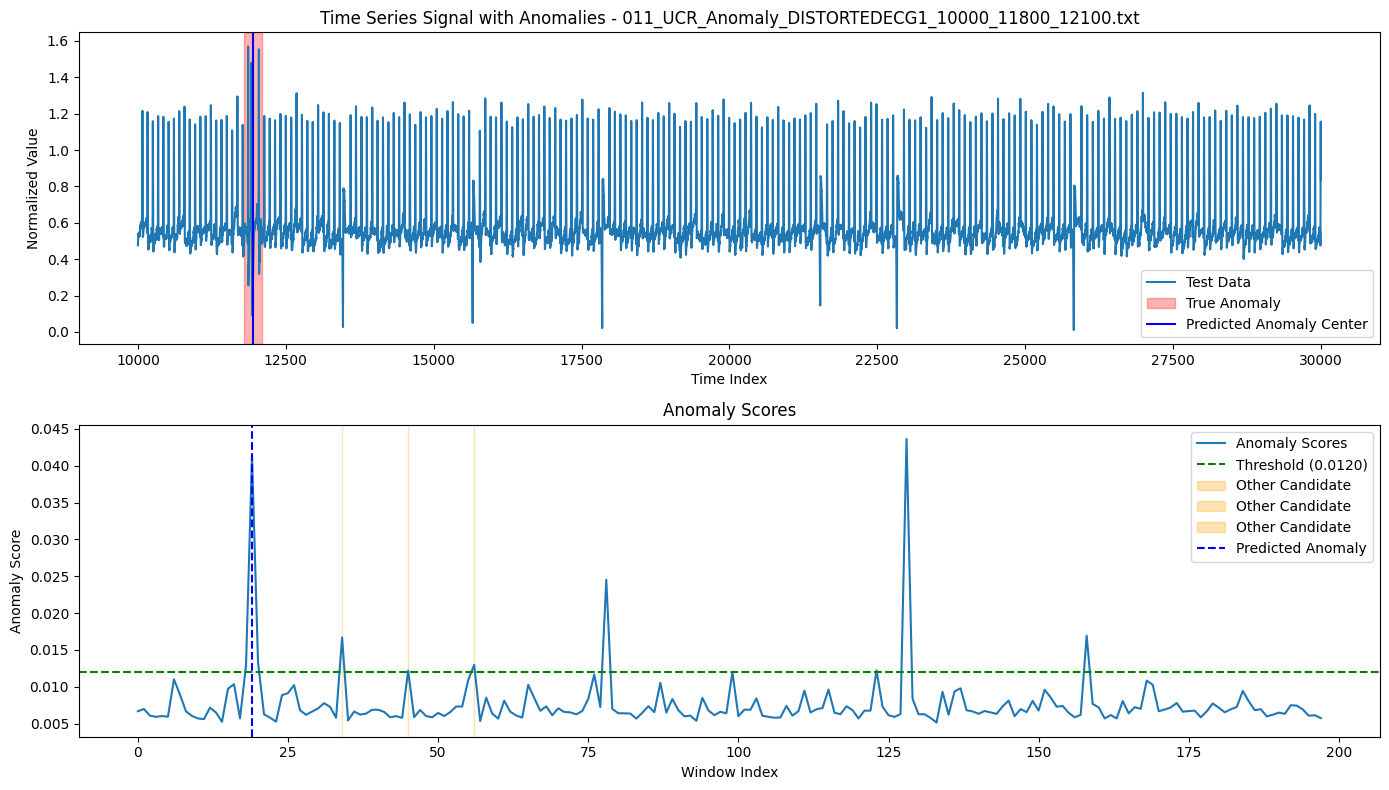

Processing file 171/225
Processing file 172/225
Processing file 173/225
Correct prediction for 054_UCR_Anomaly_DISTORTEDWalkingAceleration5_2700_5920_5979.txt.


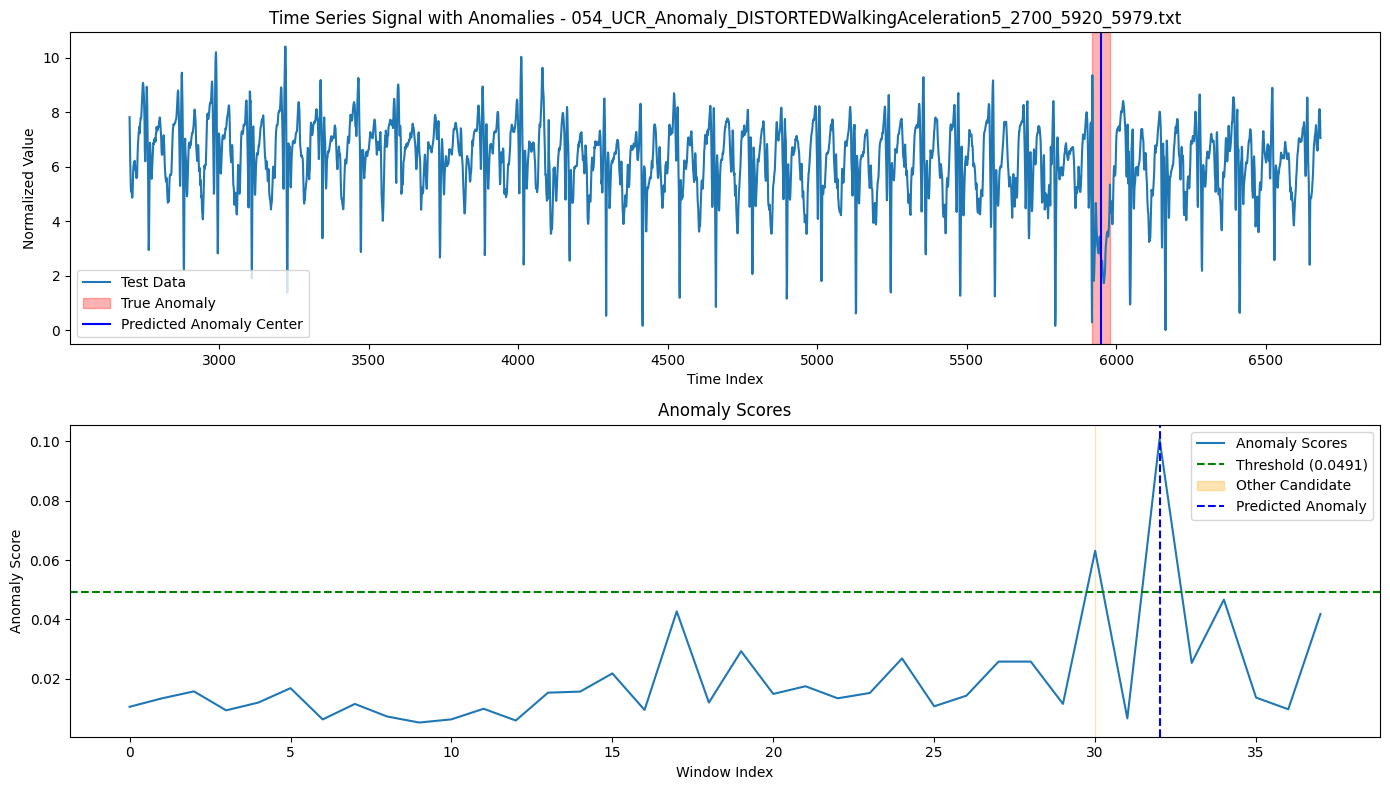

Processing file 174/225
Processing file 175/225
Processing file 176/225
Processing file 177/225
Correct prediction for 094_UCR_Anomaly_NOISEBIDMC1_2500_5400_5600.txt.


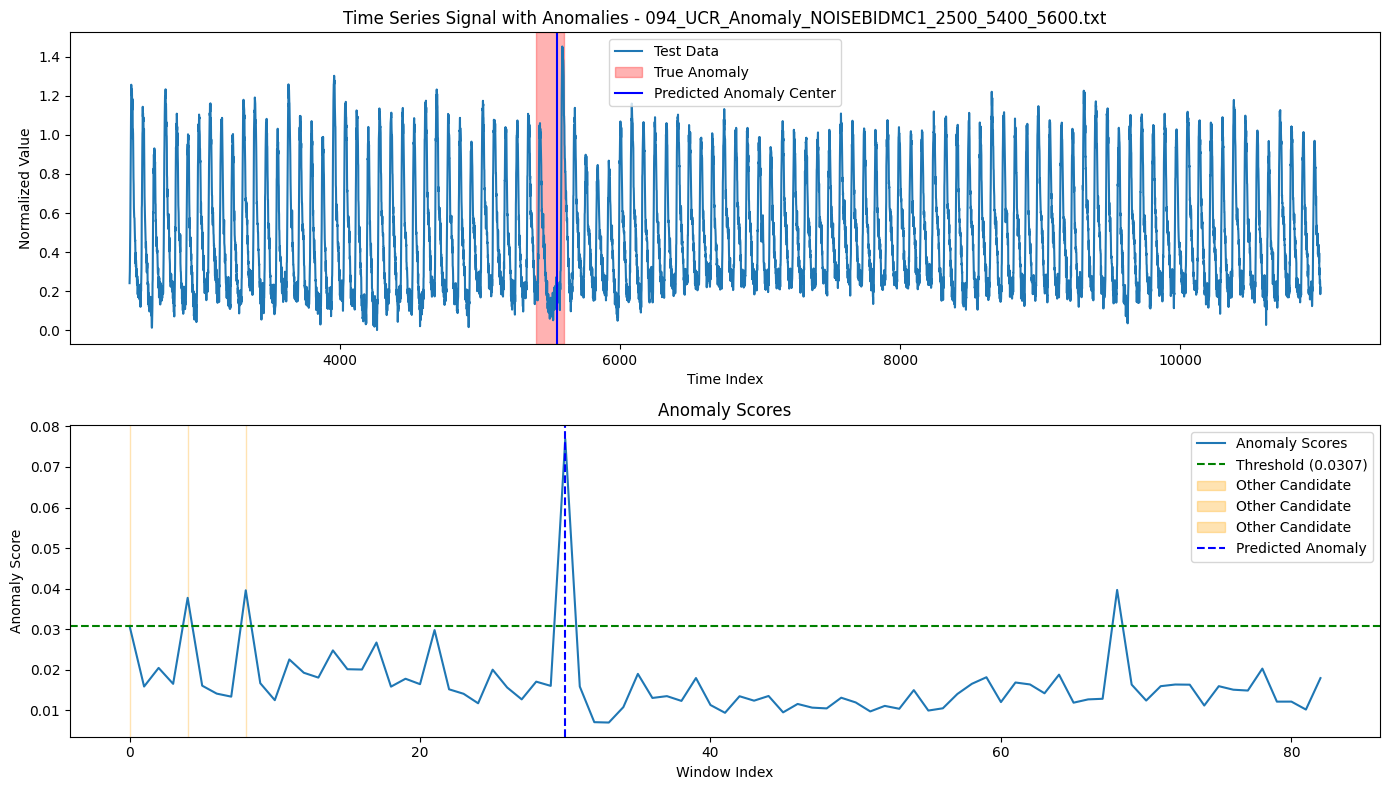

Processing file 178/225
Correct prediction for 142_UCR_Anomaly_InternalBleeding6_1500_3474_3629.txt.


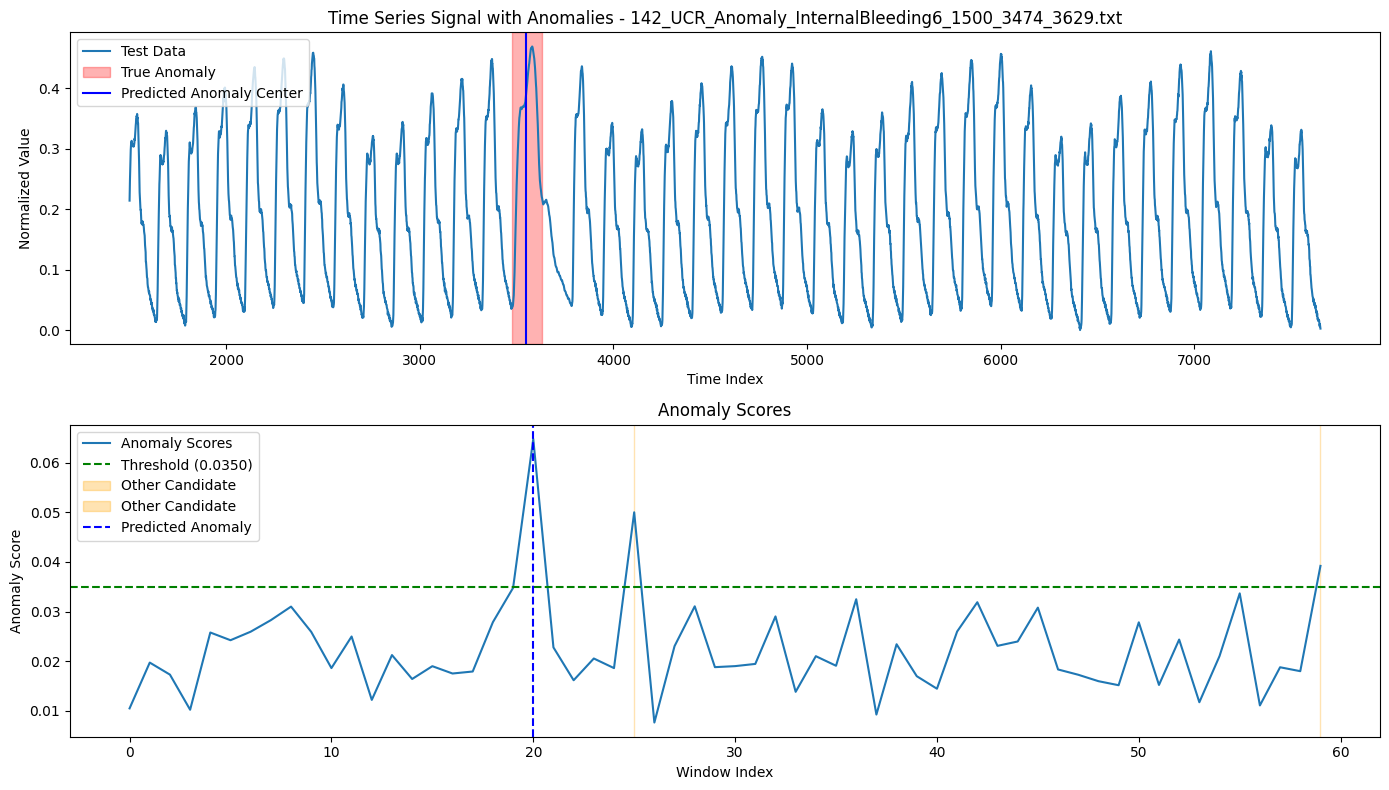

Processing file 179/225
Processing file 180/225
Skipping 206_UCR_Anomaly_CHARISten_25130_29080_29140.txt due to empty feature extraction.
Processing file 181/225
Processing file 182/225
Processing file 183/225
Correct prediction for 192_UCR_Anomaly_s20101mML2_12000_35774_35874.txt.


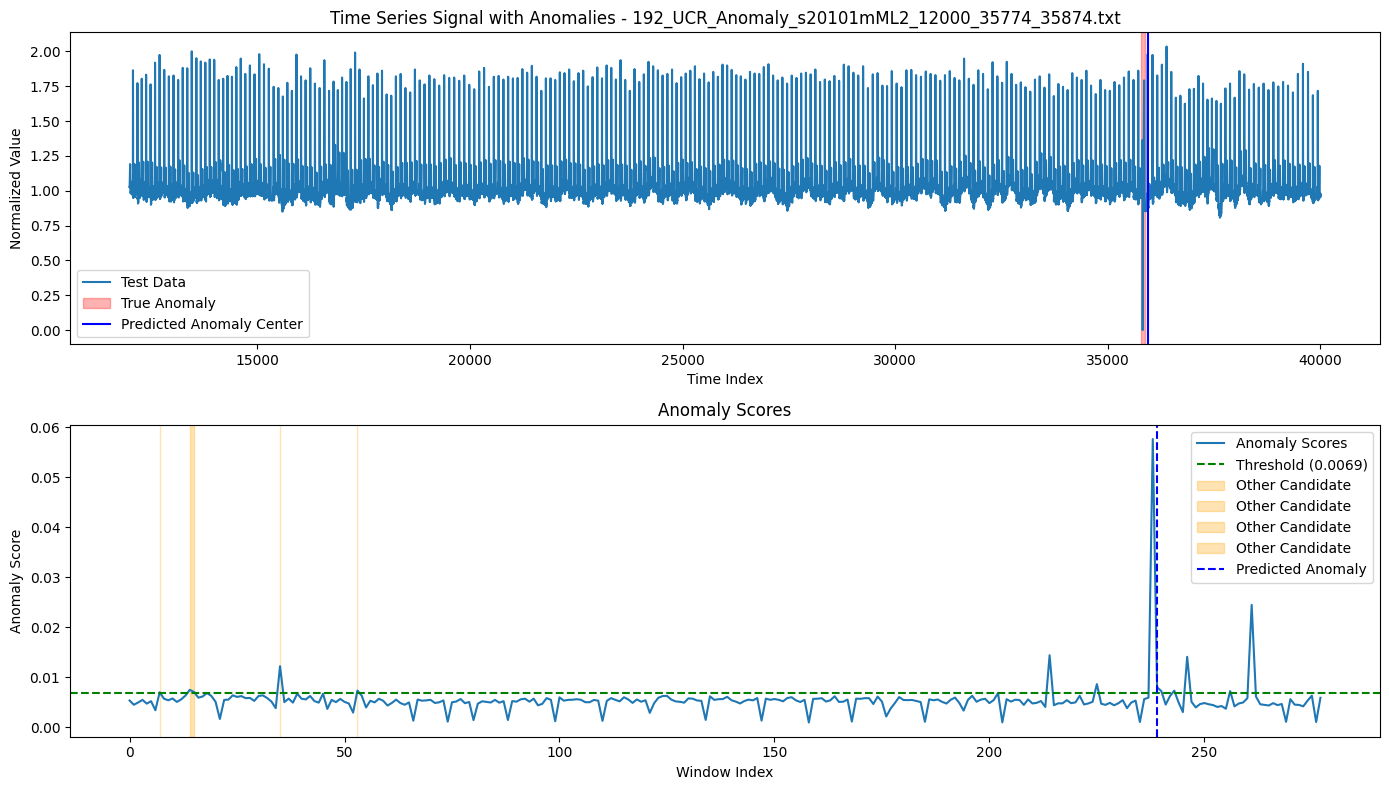

Processing file 184/225
Processing file 185/225
Processing file 186/225
Processing file 187/225
Processing file 188/225
Processing file 189/225
Correct prediction for 119_UCR_Anomaly_ECG1_10000_11800_12100.txt.


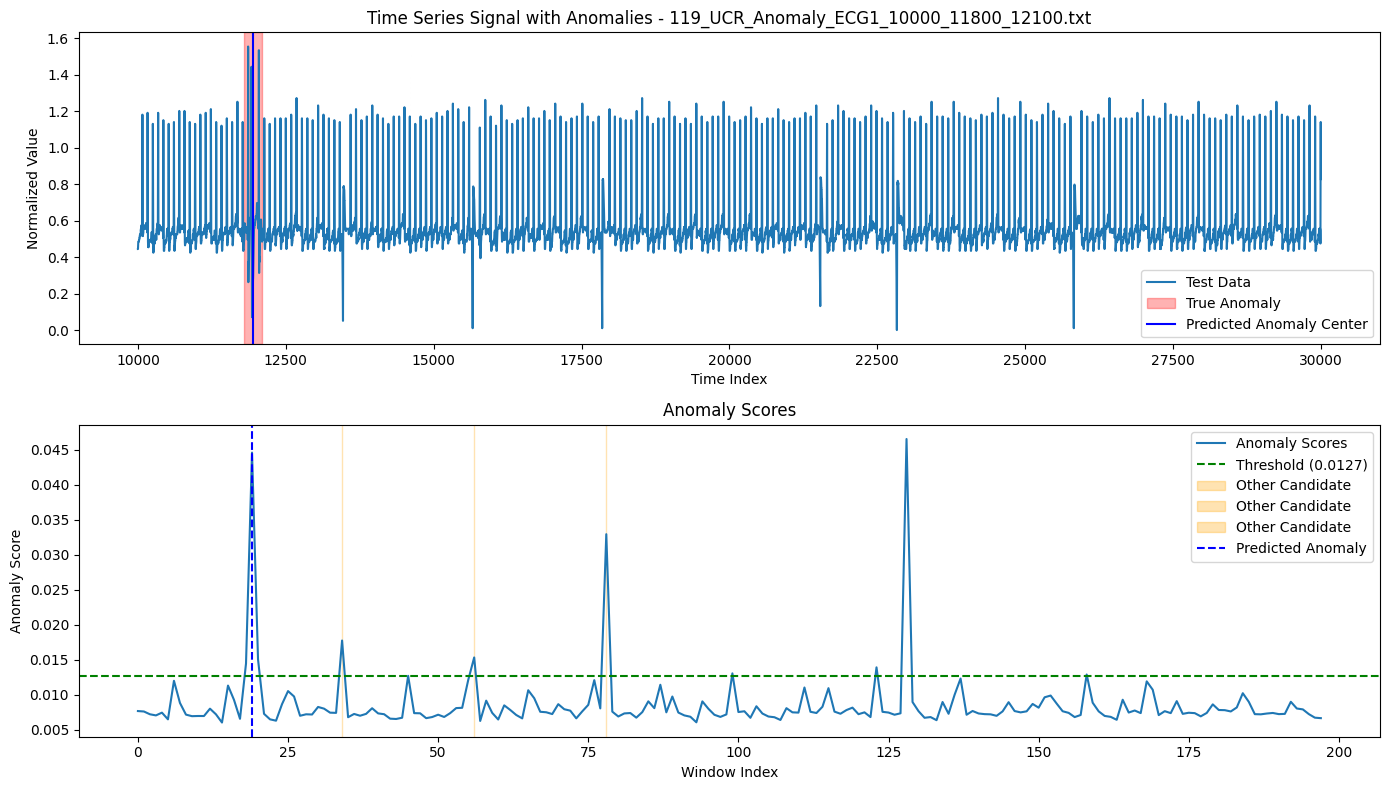

Processing file 190/225
Processing file 191/225
Processing file 192/225
Processing file 193/225
Skipping 205_UCR_Anomaly_CHARISfive_9812_28995_29085.txt due to empty feature extraction.
Processing file 194/225
Processing file 195/225
Processing file 196/225
Correct prediction for 117_UCR_Anomaly_CIMIS44AirTemperature5_4000_4852_4900.txt.


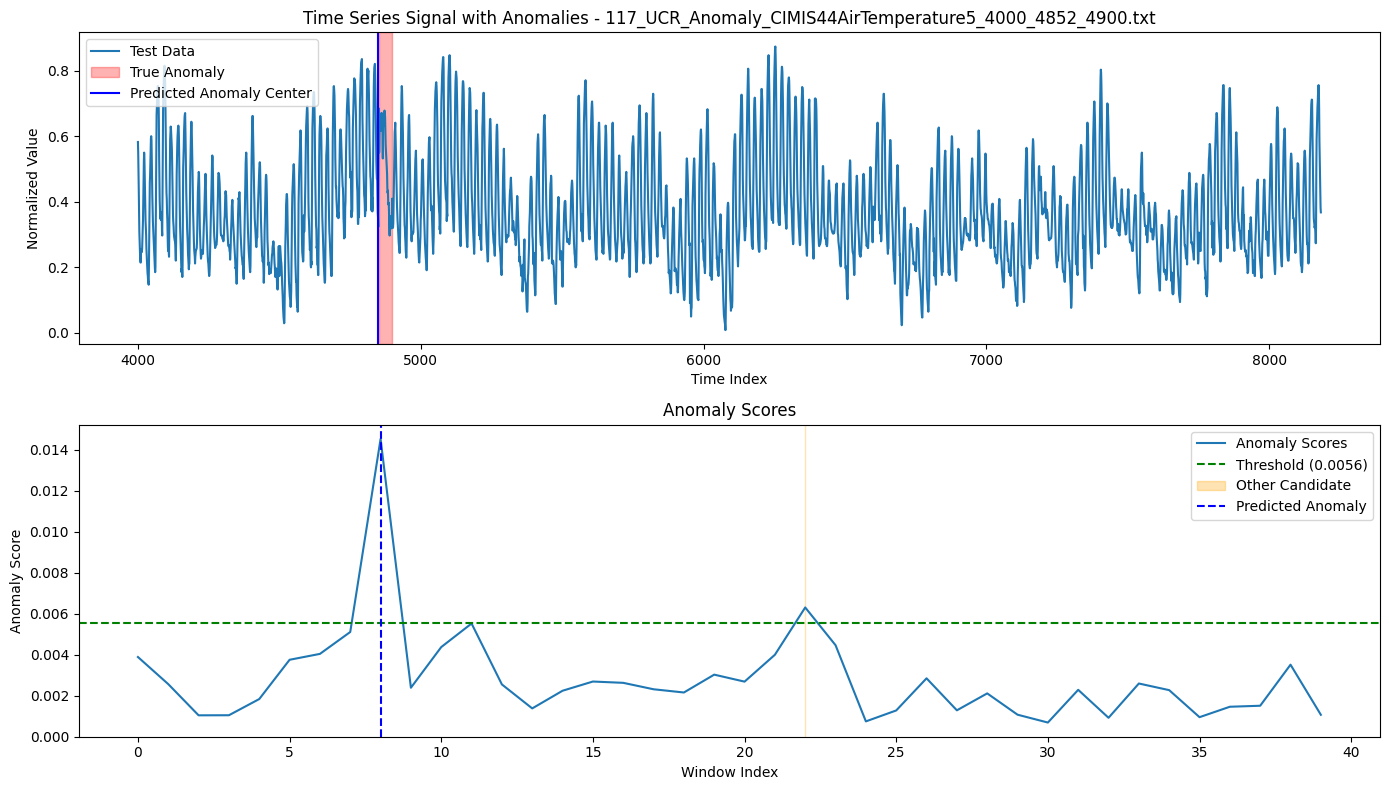

Processing file 197/225
Correct prediction for 145_UCR_Anomaly_Lab2Cmac011215EPG1_5000_17210_17260.txt.


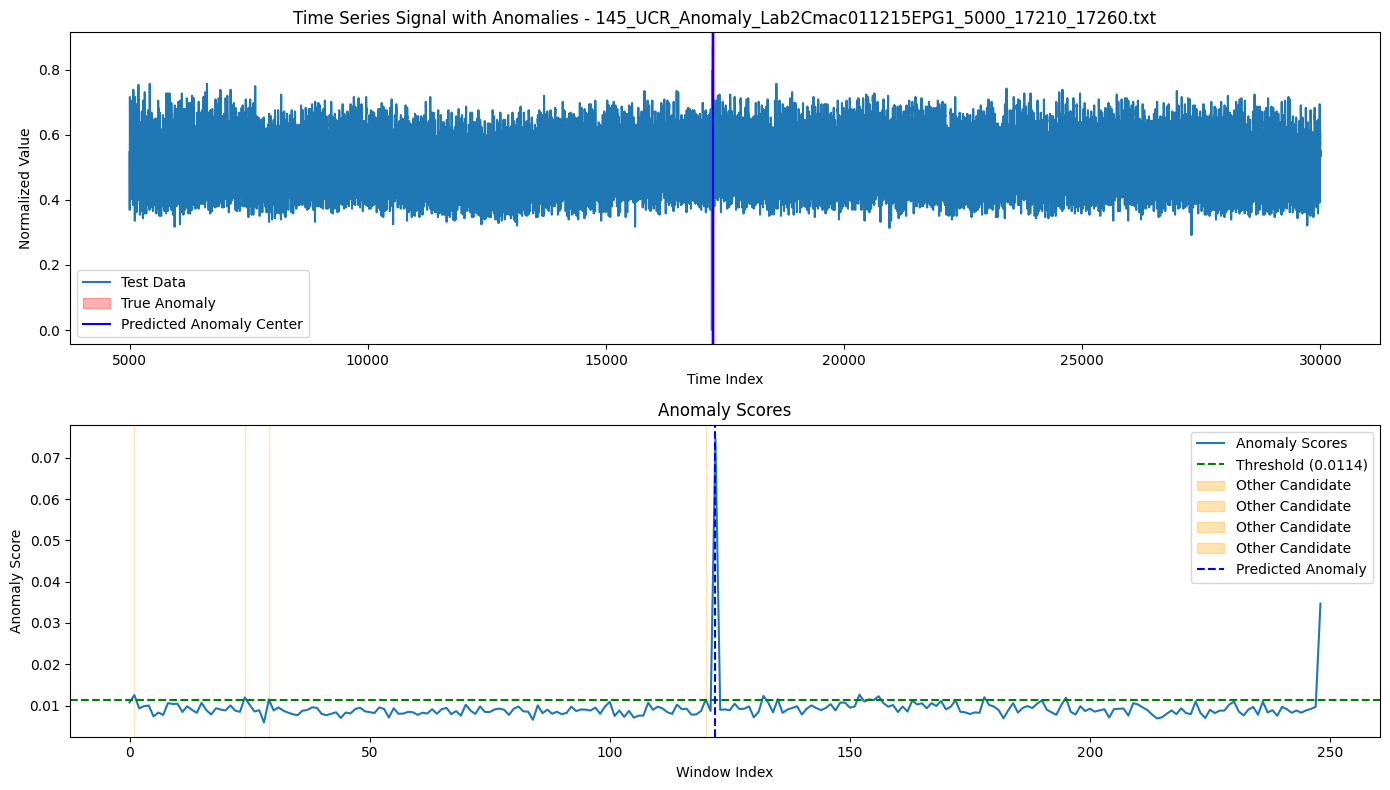

Processing file 198/225
Processing file 199/225
Processing file 200/225
Processing file 201/225
Processing file 202/225
Processing file 203/225
Processing file 204/225
Processing file 205/225
Processing file 206/225
Processing file 207/225
Processing file 208/225
Processing file 209/225
Processing file 210/225


/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_3287/3752982701.py:47: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window)
/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_3287/3752982701.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window)


Processing file 211/225
Processing file 212/225
Processing file 213/225
Correct prediction for 112_UCR_Anomaly_BIDMC1_2500_5400_5600.txt.


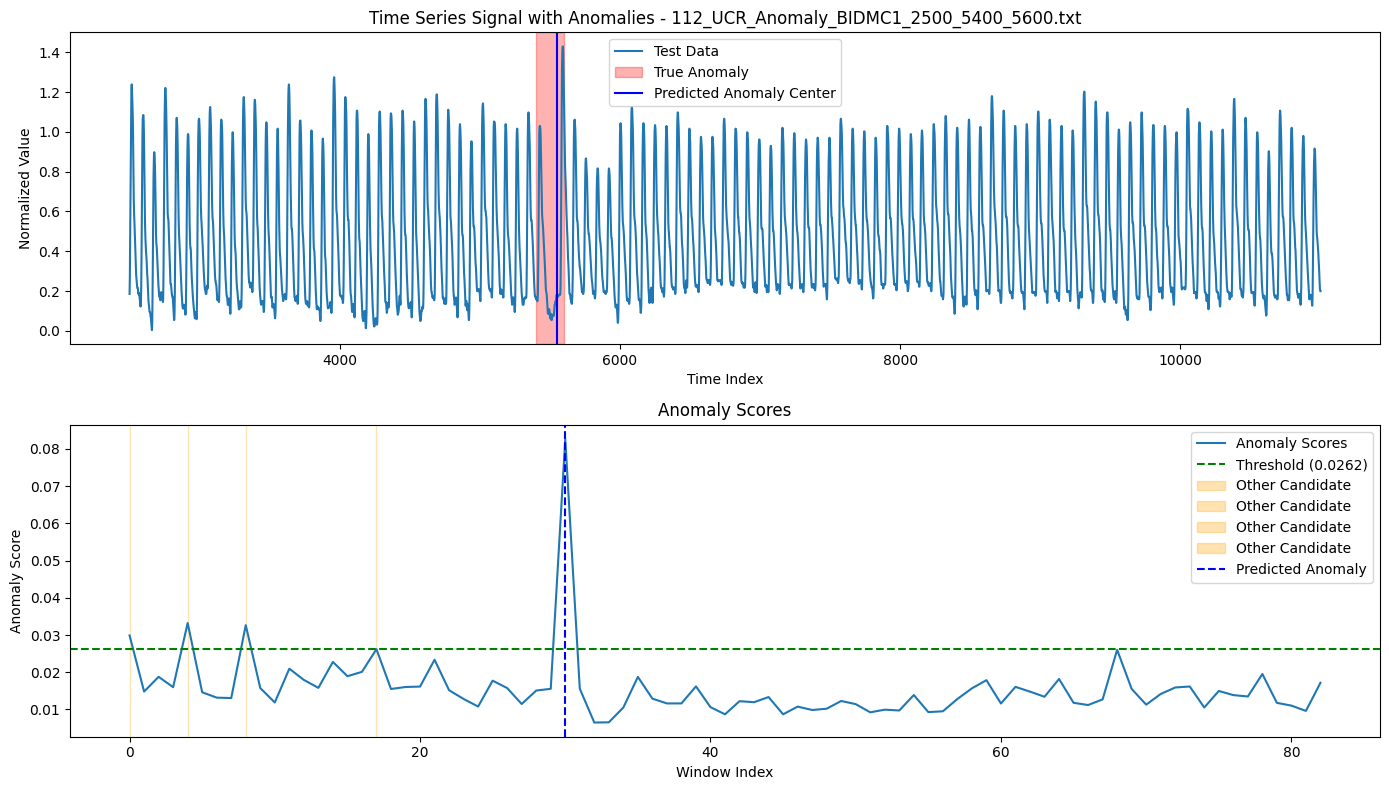

Processing file 214/225
Processing file 215/225
Correct prediction for 100_UCR_Anomaly_NOISELab2Cmac011215EPG1_5000_17210_17260.txt.


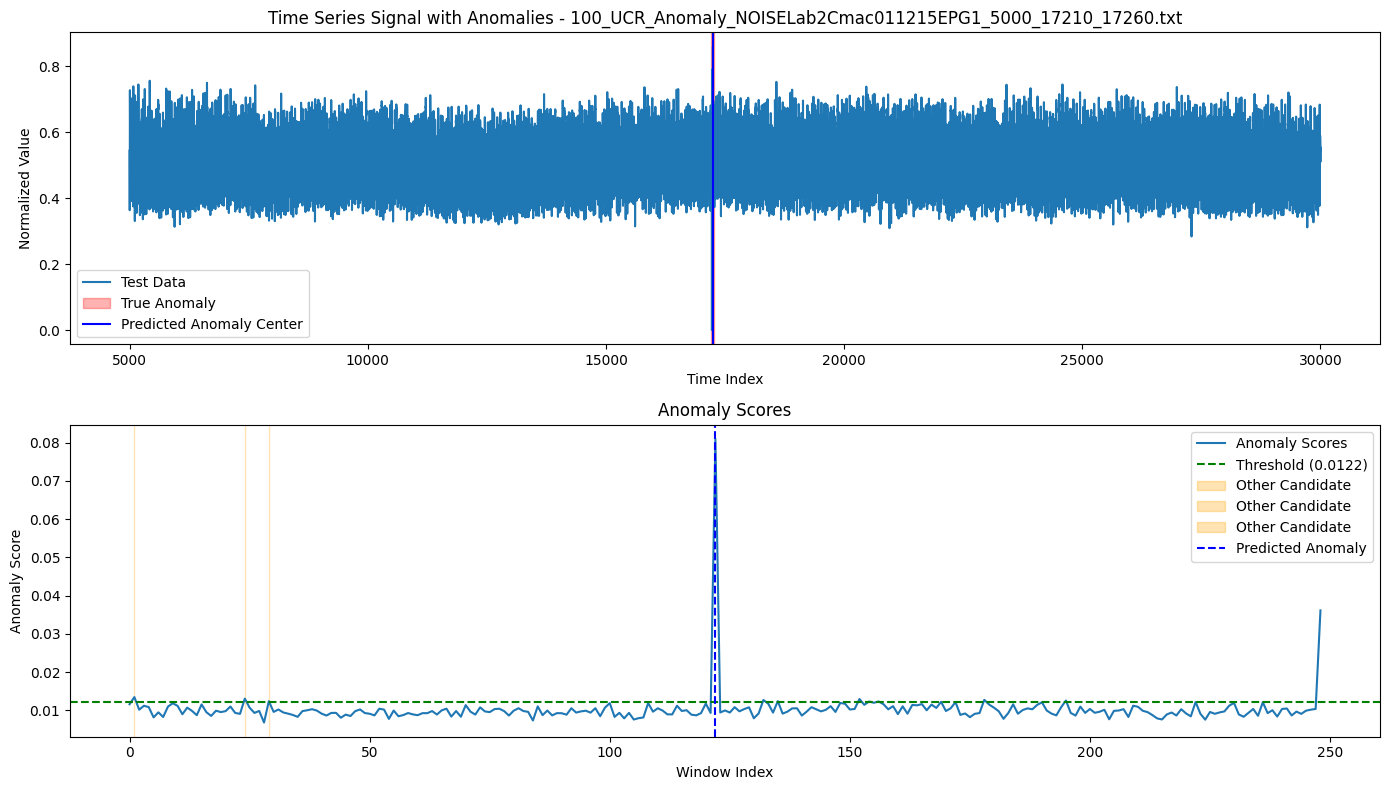

Processing file 216/225
Processing file 217/225


/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_3287/3752982701.py:47: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skewness = skew(window)
/var/folders/v2/8xwj4fhn1c1cq81kmlwzl6700000gn/T/ipykernel_3287/3752982701.py:49: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurt = kurtosis(window)


Processing file 218/225
Processing file 219/225
Processing file 220/225
Processing file 221/225
Correct prediction for 063_UCR_Anomaly_DISTORTEDgaitHunt2_18500_31200_31850.txt.


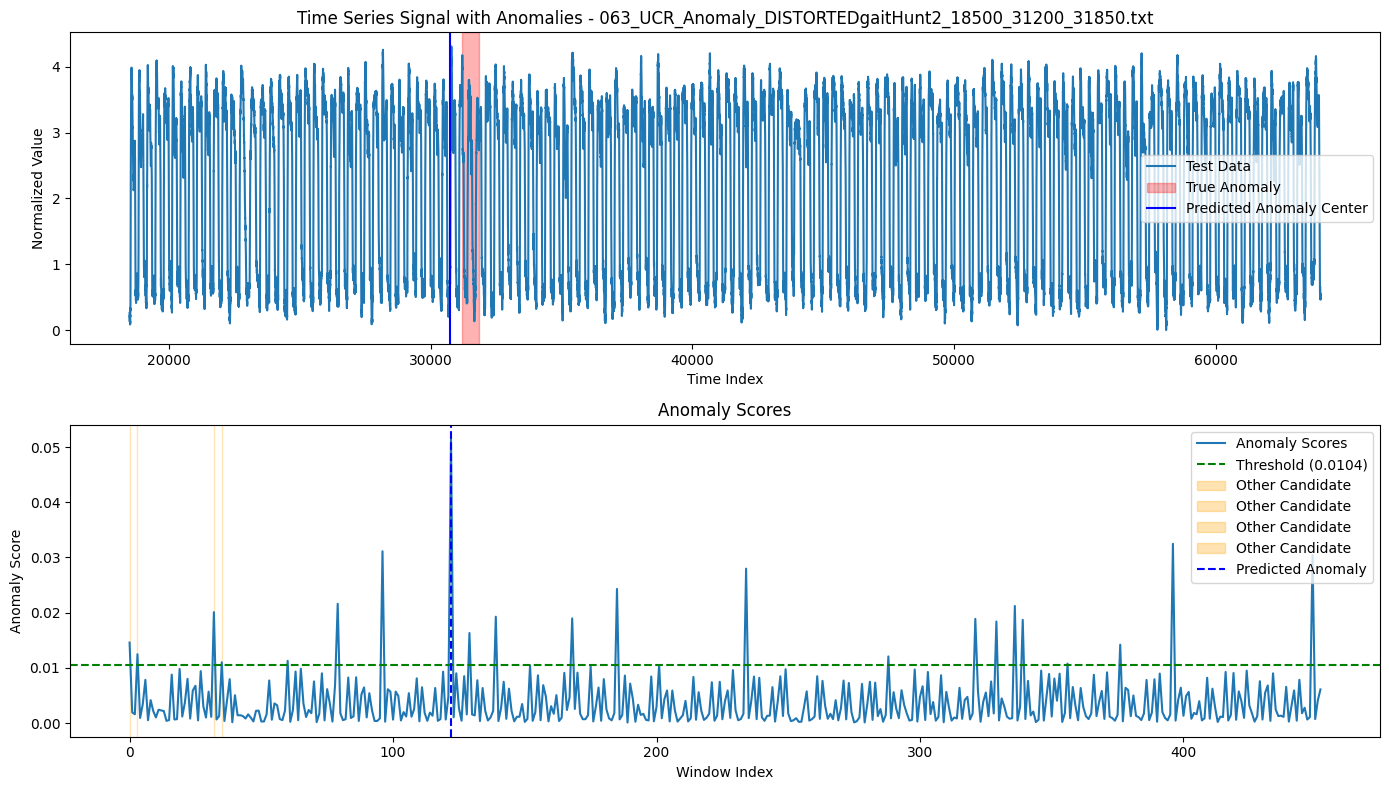

Processing file 222/225
Processing file 223/225
Processing file 224/225
Processing file 225/225


In [32]:

correct_predictions = 0
total_files = 0
anomaly_results = {anomaly_type: {'correct': 0, 'total': 0} for anomaly_type in anomaly_types_df['anomaly_type_2'].unique()}
all_true_labels = []
all_predicted_scores = []

for filename in training_testing_files:
    if filename.endswith('.txt'):
        total_files += 1
        print(f"Processing file {total_files}/{len(training_testing_files)}")  # Progress indicator

        ts = load_time_series(os.path.join(folder_path, filename))
        ts = (ts - np.min(ts)) / (np.max(ts))
        parts = filename[:-4].split('_')
        train_size = int(parts[-3])
        anomaly_start = int(parts[-2])
        anomaly_end = int(parts[-1])
        
        if anomaly_start == anomaly_end:
            anomaly_end = anomaly_start + 1  # For single-point anomalies

        #Isolation Forest
        train_features = extract_features(ts[:train_size], window_size=best_params_gru['window_size'])
        test_features = extract_features(ts[train_size:], window_size=best_params_gru['window_size'])
        if train_features.size == 0 or test_features.size == 0:
            print(f"Skipping {filename} due to empty feature extraction.")
            continue
        iso_forest = IsolationForest(**best_params_iforest, random_state=42)
        iso_forest.fit(train_features)
        iso_forest_scores = iso_forest.decision_function(test_features)

        #GRU Autoencoder
        X_train = reshape_data(ts[:train_size], window_size=best_params_gru['window_size'])
        X_test = reshape_data(ts[train_size:], window_size=best_params_gru['window_size'])
        if X_train.nelement() == 0 or X_test.nelement() == 0:
            print(f"Skipping {filename} due to insufficient data for reshaping.")
            continue
        X_train, X_test = scale_data(X_train.numpy(), X_test.numpy(), window_size=best_params_gru['window_size'])
        X_train, X_test = torch.tensor(X_train), torch.tensor(X_test)
        input_dim = X_train.size(2)
        hidden_dim = 64
        num_layers = 2
        gru_model = GRUAutoencoder(input_dim, hidden_dim, num_layers)
        train_model(gru_model, X_train, num_epochs=best_params_gru['num_epochs'], learning_rate=0.01)
        gru_model.eval()
        with torch.no_grad():
            reconstructions = gru_model(X_test)
            reconstructions = reconstructions[:, :X_test.size(1), :]
            gru_scores = nn.MSELoss(reduction='none')(reconstructions, X_test).mean(dim=2).mean(dim=1).numpy()
            if len(gru_scores) > 2:
                truncated_gru_scores = gru_scores[:-2]
            else:
                truncated_gru_scores = gru_scores 

        #truncating the longer array to match the shorter one
        min_length = min(len(iso_forest_scores), len(truncated_gru_scores))
        iso_forest_scores = iso_forest_scores[:min_length]
        truncated_gru_scores = truncated_gru_scores[:min_length]
        
        #adjusting Isolation Forest scores (positive scores show normal parts)
        iso_forest_scores_adjusted = np.where(iso_forest_scores > 0, 0, -iso_forest_scores)

        #confidence weights based on standard deviation of scores
        iso_forest_confidence = 1 / np.std(iso_forest_scores_adjusted) if np.std(iso_forest_scores_adjusted) != 0 else 0
        gru_confidence = 1 / np.std(truncated_gru_scores) if np.std(truncated_gru_scores) != 0 else 0
        
        total_confidence = iso_forest_confidence + gru_confidence
        if total_confidence == 0:
            iso_forest_weight = 0.5
            gru_weight = 0.5
        else:
            iso_forest_weight = iso_forest_confidence / total_confidence
            gru_weight = gru_confidence / total_confidence

        ensemble_scores = (iso_forest_weight * iso_forest_scores_adjusted) + (gru_weight * truncated_gru_scores)
        threshold = np.percentile(ensemble_scores, 95)
        above_threshold = ensemble_scores > threshold
        candidate_regions = []
        current_region = []

        for i, flag in enumerate(above_threshold):
            if flag:
                current_region.append(i)
            elif current_region:
                candidate_regions.append(current_region)
                current_region = []

        if current_region:
            candidate_regions.append(current_region)

        #the best contiguous region based on the highest total score
        candidate_scores = [sum(ensemble_scores[region[0]:region[-1]+1]) for region in candidate_regions]
        max_score_region = candidate_regions[candidate_scores.index(max(candidate_scores))] if candidate_scores else []
        if max_score_region:
            predicted_anomaly_index = (max_score_region[0] + max_score_region[-1]) // 2
            predicted_center = predicted_anomaly_index * best_params_gru['window_size'] + train_size + best_params_gru['window_size']/2
        else:
            predicted_anomaly_index = 0
            predicted_center = train_size

        is_correct = evaluate_prediction(predicted_center, anomaly_start, anomaly_end)
        if is_correct:
            print(f"Correct prediction for {filename}.")
            correct_predictions += 1

        anomaly_type = filename_to_anomaly_type.get(filename, "Unknown")
        if anomaly_type in anomaly_results:
            anomaly_results[anomaly_type]['total'] += 1
            if is_correct:
                anomaly_results[anomaly_type]['correct'] += 1
               
                plt.figure(figsize=(14, 8))
                
                #Time Series Signal
                plt.subplot(2, 1, 1)
                test_range = range(train_size, train_size + len(ts[train_size:train_size + len(X_test) * best_params_gru['window_size']]))
                plt.plot(test_range, ts[train_size:train_size + len(test_range)], label='Test Data')
                plt.axvspan(anomaly_start, anomaly_end, color='red', alpha=0.3, label='True Anomaly')
                plt.axvline(predicted_center, color='blue', label='Predicted Anomaly Center')
                plt.title(f'Time Series Signal with Anomalies - {filename}')
                plt.xlabel('Time Index')
                plt.ylabel('Normalized Value')
                plt.legend()
                #Anomaly Scores
                plt.subplot(2, 1, 2)
                plt.plot(range(len(ensemble_scores)), ensemble_scores, label='Anomaly Scores')
                plt.axhline(y=threshold, color='green', linestyle='--', label=f'Threshold ({threshold:.4f})')
                for region in candidate_regions[:4]:
                    if region != max_score_region:
                        plt.axvspan(region[0], region[-1], color='orange', alpha=0.3, label='Other Candidate')
                plt.axvline(predicted_anomaly_index, color='blue', linestyle='--', label='Predicted Anomaly')
                plt.title('Anomaly Scores')
                plt.xlabel('Window Index')
                plt.ylabel('Anomaly Score')
                plt.legend()
                plt.tight_layout()
                plt.show()


        true_labels = np.zeros(len(ensemble_scores))
        true_labels[anomaly_start // best_params_gru['window_size']:(anomaly_end // best_params_gru['window_size']) + 1] = 1
        all_true_labels.extend(true_labels)
        all_predicted_scores.extend(ensemble_scores)


In [34]:

accuracy = correct_predictions / total_files if total_files > 0 else 0
print(f"Overall Accuracy: {accuracy:.2f}")
f1 = f1_score(all_true_labels, [1 if score > 0 else 0 for score in all_predicted_scores])
roc_auc = roc_auc_score(all_true_labels, all_predicted_scores)
precision = precision_score(all_true_labels, [1 if score > 0 else 0 for score in all_predicted_scores])
recall = recall_score(all_true_labels, [1 if score > 0 else 0 for score in all_predicted_scores])

print(f"F1 Score: {f1:.2f}")
print(f"AUC ROC: {roc_auc:.2f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.2f}")
for anomaly_type, result in anomaly_results.items():
    correct = result['correct']
    total = result['total']
    print(f"Anomaly type: {anomaly_type}, Correct predictions: {correct}, Total cases: {total}, Accuracy: {correct*100/total if total > 0 else 0:.1f}%")


Overall Accuracy: 0.13
F1 Score: 0.01
AUC ROC: 0.63
Precision: 0.003
Recall: 1.00
Anomaly type: unusual_pattern, Correct predictions: 2, Total cases: 20, Accuracy: 10.0%
Anomaly type: missing_drop, Correct predictions: 0, Total cases: 3, Accuracy: 0.0%
Anomaly type: noise, Correct predictions: 0, Total cases: 22, Accuracy: 0.0%
Anomaly type: missing_peak, Correct predictions: 3, Total cases: 13, Accuracy: 23.1%
Anomaly type: local_drop, Correct predictions: 5, Total cases: 18, Accuracy: 27.8%
Anomaly type: local_peak, Correct predictions: 0, Total cases: 22, Accuracy: 0.0%
Anomaly type: outlier, Correct predictions: 8, Total cases: 21, Accuracy: 38.1%
Anomaly type: amplitude_change, Correct predictions: 4, Total cases: 21, Accuracy: 19.0%
Anomaly type: reversed, Correct predictions: 3, Total cases: 19, Accuracy: 15.8%
Anomaly type: frequency_change, Correct predictions: 4, Total cases: 25, Accuracy: 16.0%
Anomaly type: time_warping, Correct predictions: 0, Total cases: 4, Accuracy: 0.0